# Film Analysis with IMDb Data

### Problem Statement

Can we determine the factors that lead to a high rating

### Goals

- Determine the factors that lead to a high imdb rating for feature films
- using ratings and review data obtained from IMDB for the top films according to IMDB.


In [2]:
# Import our modules
import pandas as pd
import numpy as np

import urllib
import requests
import json
from bs4 import BeautifulSoup

import re
import pickle
 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Lets use imdbpie to grab the top 250 movies

In [2]:
# import Imdb from imdbpie
from imdbpie import Imdb

In [3]:
# grab top 250 movies using imdbpie
imdb = Imdb()
imdb = Imdb(anonymize=True)

In [4]:
top_250 = imdb.top_250()

In [5]:
df_250 = pd.DataFrame(top_250)

In [9]:
# Check for the oldest movie in the list
df_250['year'].min()

u'1921'

In [6]:
# Pull ids out into list
ids_250 = df_250['tconst']

In [7]:
# Save list of ids out with pickle

with open('ids_250_pickle', 'wb') as fp:
    pickle.dump(ids_250, fp)

In [8]:
with open ('ids_250_pickle', 'rb') as fp:
    ids_250 = pickle.load(fp)

### Lets grab a bunch of movie title ids from imdb

from the past 100 years or so, making sure we cover the timespan of our top 250. <br>
Let's start at 1910 as it is mentioned as about the time Hollywood became a thing. <br>

In [10]:
# Function to request and soupify our results
def soupy(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(url, headers=headers)
    content = response.content
    soup = BeautifulSoup(content, "lxml")
    return soup

In [11]:
# url formaters, search imdb by year (from 1910 -) and grab first 3 pages (150 most popular movies) for each year
year_url = 'http://www.imdb.com/search/title?year={},{}&title_type=feature&sort=moviemeter,asc&page={}&ref_=adv_nxt'
years = range(1910,2018)
pages = range(1,4)

In [12]:
# Function to grab title ids from imdb search pages
def get_titles(url):
    soup = soupy(url)
    try:
        titles = soup.findAll('h3', class_="lister-item-header")
        for i in titles:
            tt_link = i.find('a')['href']
            tt_id = tt_link.split('/')[2]
            title_ids.append(tt_id)      
    except AttributeError:
        tt_id = None     

In [13]:
# Instantiate an empty list to hold our ids
title_ids = []

# Loop over each year and the first three pages to grab title ids
for year in years:
    for page in pages:
        get_titles(year_url.format(year,year,page))

In [14]:
len(title_ids)

16132

In [16]:
# Append top 250 ids to most popular per year
for i in ids_250:
    title_ids.append(i)

In [17]:
# Delete duplicate ids
title_ids_set = list(set(title_ids))
len(title_ids_set)

16136

In [18]:
# Pickle ids
with open('ids_pickle', 'wb') as fp:
    pickle.dump(title_ids_set, fp)

### Lets test grabbing our info using both the OMDBapi and imdb-pie

In [26]:
%%timeit -o
# Time first 100 from OMDB
title_request = 'http://www.omdbapi.com/?i={}&plot=full'
info_omdb = []
for i in title_ids_set[:50]:
    url = title_request.format(i)
    response = requests.get(url)
    info_omdb.append(response.json()) 

1 loop, best of 3: 3.66 s per loop


<TimeitResult : 1 loop, best of 3: 3.66 s per loop>

In [29]:
%%timeit -o
# Time first 100 from OMDB
title_request = 'http://www.omdbapi.com/?i={}&plot=full'
info_omdb = []
for i in title_ids_set[:50]:
    url = title_request.format(i)
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    response = requests.get(url, headers=headers)
    info_omdb.append(response.json())

1 loop, best of 3: 2.95 s per loop


<TimeitResult : 1 loop, best of 3: 2.95 s per loop>

In [28]:
%%timeit -o
# Time first 100 from imdbpie
info_imdbpie = []
for i in title_ids_set[:50]:
    title = imdb.get_title_by_id(i)
    info_imdbpie.append(title)

1 loop, best of 3: 1min 47s per loop


<TimeitResult : 1 loop, best of 3: 1min 47s per loop>

In [31]:
# Take a look at the OMDB info
info_omdb_df = pd.DataFrame(info_omdb)
info_omdb_df.head(2)

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,N/A,N/A,Poland,Aleksander Hertz,N/A,Polish,N/A,N/A,N/A,N/A,N/A,True,N/A,"Historia, jakich wiele",movie,N/A,1912,tt0437222,N/A,N/A
1,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",N/A,USA,Nathan Juran,"Action, Adventure, Horror",English,N/A,"Gor, a powerful criminal brain from the planet...",https://images-na.ssl-images-amazon.com/images...,APPROVED,01 Oct 1957,True,71 min,The Brain from Planet Arous,movie,Ray Buffum (screenplay),1957,tt0050210,5.3,"1,109"


In [33]:
# Take a look at the imdbpie info
# info_imdbpie

In [34]:
feats = ['rating','title', 'year', 'cast_summary', 'genres', 'imdb_id', 'directors_summary', 'certification','type']
df_imdbpie_test = pd.DataFrame([{fn: getattr(f, fn) for fn in feats} for f in info_imdbpie])

In [35]:
df_imdbpie_test.head(2)

,cast_summary,certification,directors_summary,genres,imdb_id,rating,title,type,year
0,[],None,[<Person: Aleksander Hertz (nm0381076)>],None,tt0437222,NaN,"Historia, jakich wiele",feature,1912
1,"[<Person: John Agar (nm0000730)>, <Person: Joy...",Approved,[<Person: Nathan Juran (nm0432846)>],"[Action, Adventure, Horror, Sci-Fi, Thriller]",tt0050210,5.3,The Brain from Planet Arous,feature,1957


---
#### Which should we use?
The OMDBapi is working quite a bit faster than imdbpie here.  And looking at the data it returns <br>
(a json item) it will be easier to bring into a dataframe. <br> 

Imdbpie returns class instances with some embedded classes within them that will need a few more steps <br>
to clean when bringing into a dataframe. 

Though Imdb-pie's info is a bit more complete(includes producers, music ... in credits), <br>

So, I will use the OMDBapi, given that it is working about 16 times faster, and go back to <br>
scrap a few other items from IMDB's site.

---
### Now lets grab the info for all of our titles using the OMDbapi

In [ ]:
# Pickle ids
with open ('ids_pickle', 'rb') as fp:
    title_ids_set = pickle.load(fp)

In [334]:
# List to capture title info
movie_info = []

In [384]:
# Grab info for all titles using omdbapi
# The list of ids was subsetted and rerun for each group to avoid overloading the api
for t in title_ids_set[16000:]:
    args = {'i':t,'plot':'short','r':'json', 'tomatoes':'True'}
    url = 'http://www.omdbapi.com/' 
    r = requests.get(URL, params=args)
    movie_info.append(r.json())

In [403]:
# Convert info to dataframe
movie_df = pd.DataFrame(movie_info)

In [404]:
# Drop any duplicates
movie_df.drop_duplicates(subset='imdbID', inplace=True)

(16137, 36)

In [405]:
# Drop any null ids that resulted from our connection being kicked
movie_df = movie_df[movie_df.imdbID.notnull()]

In [406]:
movie_df.shape

(16136, 36)

In [407]:
# Export dataframe with pickle
movie_df.to_pickle('movie_df.pkl')

In [4]:
# Import dataframe with pickle
movie_df = pd.read_pickle('movie_df.pkl')

In [5]:
movie_df.head(2)

,Actors,Awards,BoxOffice,Country,DVD,Director,Error,Genre,Language,Metascore,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,N/A,N/A,N/A,Poland,N/A,Aleksander Hertz,NaN,N/A,Polish,N/A,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",N/A,N/A,USA,27 Feb 2001,Nathan Juran,NaN,"Action, Adventure, Horror",English,N/A,...,N/A,N/A,N/A,N/A,N/A,N/A,http://www.rottentomatoes.com/m/the_brain_from...,N/A,N/A,N/A


In [6]:
movie_df.columns

Index([u'Actors', u'Awards', u'BoxOffice', u'Country', u'DVD', u'Director',
       u'Error', u'Genre', u'Language', u'Metascore', u'Plot', u'Poster',
       u'Production', u'Rated', u'Released', u'Response', u'Runtime', u'Title',
       u'Type', u'Website', u'Writer', u'Year', u'imdbID', u'imdbRating',
       u'imdbVotes', u'tomatoConsensus', u'tomatoFresh', u'tomatoImage',
       u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoRotten',
       u'tomatoURL', u'tomatoUserMeter', u'tomatoUserRating',
       u'tomatoUserReviews'],
      dtype='object')

In [7]:
# Drop unneeded columns
drop_columns = [u'DVD', u'Error', u'Poster', u'Response', u'Type', u'Website',
       u'tomatoConsensus', u'tomatoFresh', u'tomatoImage',
       u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoRotten',
       u'tomatoURL', u'tomatoUserMeter', u'tomatoUserRating',
       u'tomatoUserReviews']

In [8]:
movie_df.drop(drop_columns, axis=1, inplace=True)

In [10]:
# Replace N/A with nan
movie_df = movie_df.applymap(lambda x: np.nan if x == 'N/A' else x)

In [23]:
# Drop titles without an imdb rating
rated_df = movie_df[movie_df['imdbRating'].notnull()]

In [24]:
rated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14937 entries, 1 to 20459
Data columns (total 19 columns):
Actors        14876 non-null object
Awards        7460 non-null object
BoxOffice     2098 non-null object
Country       14913 non-null object
Director      14896 non-null object
Genre         14750 non-null object
Language      14265 non-null object
Metascore     3542 non-null object
Plot          14188 non-null object
Production    11779 non-null object
Rated         11602 non-null object
Released      14529 non-null object
Runtime       14456 non-null object
Title         14937 non-null object
Writer        14798 non-null object
Year          14937 non-null object
imdbID        14937 non-null object
imdbRating    14937 non-null object
imdbVotes     14931 non-null object
dtypes: object(19)
memory usage: 2.3+ MB


In [25]:
rated_df.reset_index(drop=True, inplace=True)

In [26]:
rated_df.to_pickle('rated_films_first.pkl')

### Link to notebook used to scrape budget and producer info from IMDb

https://git.generalassemb.ly/anthonysull/project-6-apis-randomforests/blob/master/P6_Budget_Gross_Producers.ipynb

---
# Data Cleaning

### Let's convert our numeric features to numeric

In [488]:
import warnings
warnings.filterwarnings('ignore')

In [509]:
rated_df = pd.read_pickle('rated_films_first.pkl')

In [510]:
# Strip imdbvotes string of commas
rated_df['imdbVotes'] = rated_df.loc[:,'imdbVotes'].str.replace(',','')

In [511]:
# List of columns to convert to numeric
to_convert = ['imdbRating', 'Metascore', 'Year', 'imdbVotes']

In [512]:
# Loop through list of columns and convert
for i in to_convert:
    rated_df[i] = rated_df.loc[:,i].apply(pd.to_numeric)

In [513]:
rated_df.describe()

,Metascore,Year,imdbRating,imdbVotes
count,3542.000000,14937.000000,14937.000000,1.493100e+04
mean,57.476285,1966.674299,6.528560,3.425068e+04
std,18.419900,29.252732,1.041723,9.456518e+04
min,1.000000,1910.000000,1.300000,5.000000e+00
25%,44.000000,1942.000000,6.000000,5.240000e+02
50%,58.000000,1967.000000,6.700000,2.582000e+03
75%,71.000000,1992.000000,7.200000,2.222950e+04
max,100.000000,2017.000000,9.500000,1.771273e+06


### Convert release date to datetime

In [514]:
# Lets convert release date to datetime
from datetime import datetime
rated_df['Release_Date'] = pd.to_datetime(rated_df.loc[:,'Released'],format='%d %b %Y')

### Clean production column

In [515]:
rated_df.Production.nunique()

1549

In [516]:
rated_df.Production.value_counts()[:50]

Paramount Pictures                          718
MGM                                         565
Universal Pictures                          443
Warner Home Video                           431
Warner Bros. Pictures                       425
United Artists                              390
20th Century Fox                            369
Columbia Pictures                           356
MGM Home Entertainment                      321
20th Century Fox Film Corporation           308
Warner Bros.                                307
Sony Pictures Home Entertainment            290
Criterion Collection                        241
MCA Universal Home Video                    215
WARNER BROTHERS PICTURES                    204
Twentieth Century Fox Home Entertainment    201
Universal                                   192
Sony Pictures Entertainment                 141
Paramount Home Video                        137
Sony Pictures                               108
New Line Cinema                         

In [517]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [518]:
choices = set(rated_df['Production'])
process.extract('Fox', choices, limit=15)

[(u'Fox', 100),
 (u'20th Century Fox', 90),
 (u'Fox Lorber', 90),
 (u'Century Fox', 90),
 (u'Fox Walden', 90),
 (u'Fox Home Entertainment', 90),
 (u'Fox Atomic', 90),
 (u'Fox Searchlight', 90),
 (u'Fox International', 90),
 (u'Fox Film Corporation', 90),
 (u'Fox Films', 90),
 (u'Twentieth Century Fox', 90),
 (u'CBS/Fox', 90),
 (u'20th Century-Fox', 90),
 (u'Fox Searchlight Pictures', 90)]

In [519]:
# Create a dictionary of production company replacements 
replacements = {
    'Production': {
        r'^Howco.*': 'Howco International Pictures',
        r'^Sony.*': 'Sony Pictures',
        r'^Twentieth Century.*': '20th Century Fox',
        r'^Twentieth Century Fox.*': '20th Century Fox',
        r'^20th.*': '20th Century Fox',
        r'^Century Fox': '20th Century Fox',
        r'^Fox Film.*': '20th Century Fox',
        r'^Fox International': '20th Century Fox',
        r'^Fox Home.*': '20th Century Fox',
        r'^Fox': '20th Century Fox',
        r'^Fox Searchlight.*': 'Fox Searchlight',
        r'^21st Century.*': '21st Century Film',
        r'^Tri[\sSs][St].*': 'TriStar Pictures',
        r'^Columbia Tr.*': 'TriStar Pictures',
        r'^Columbia.*': 'Columbia Pictures',
        r'^Cosm.*': 'Cosmopolitan Productions',
        r'^Toho.*': 'Toho Company',
        r'^MGM.*': 'MGM',
        r'^Metro[ -]G.*': 'MGM',
        r'^Metro.*':'Metro Pictures',
        r'^Vestron.*':'Vestron Pictures',
        r'^Milestone Fil.*':'Milestone Film',
        r'^W[Aa][Rr]?[Nn][Ee][Rr]s?\s?[BH].*':'Warner Brothers',
        r'^WARNER': 'Warner Brothers',
        r'^Warner I.*': 'Warner Independent',
        r'^Walter W.*':'Walter Wanger',
        r'^Water Bearer.*':'Water Bearer Films',
        r'^Arthur Mayer.*':'Arthur Mayer Edward Kingsley I',
        r'^Path[^f].*': 'Pathe',
        r"^Lions?[Gg].*.*": 'Lionsgate Films',
        r"^Lions?'?s?\sG.*": "Lion's Gate Films",
        r"^MCA.*": 'MCA Universal',
        r"^Universum F.*":'Universum Film',
        r'^New Li.*': "New Line Cinema",
        r'^New World.*':'New World Pictures',
        r'^RKO.*':'RKO Pictures',
        r'^Dream\s?W.*': 'DreamWorks',
        r'^Paramou.*':'Paramount Pictures',
        r'^Mir[ai]max.*': 'Miramax Films',
        r'^Allied Artists.*':'Allied Artists Pictures',
        r'^Amazon.*': 'Amazon Studios',
        r'^Cinerama.*':'Cinerama',
        r'^Artisan.*':'Artisan Pictures',
        r'^Pacific Arts.*':'Pacific Arts',
        r'^IFC.*':'IFC Films',
        r'^Magnolia.*':'Magnolia Pictures',
        r'^Magnet.*':'Magnet Releasing',
        r'^Weinstein.*':'The Weinstein Co.',
        r'^The Weinstein Co.*': 'The Weinstein Co.',
        r'^Winstar.*':'Winstar Cinema',
        r'^BFI.*':'British Film Institute',
        r'^VCI.*':'VCI Entertainment',
        r'^Home Box.*':'HBO',
        r'^HBO.*':'HBO',
        r'^Criterion.*':'The Criterion Collection',
        r'^American Int.*':'American International Pictures',
        r'^Independent Int.*':'Independent International Pictures',
        r'^Independ[ae]nt Pi.*':'Independent Pictures',
        r'^Relativity.*':'Relativity Media',
        r'^STARZ MEDIA.*': 'Starz',
        r'^Associated First National P.*': 'First National Pictures',
        r'^First National P.*': 'First National Pictures',
        r'^Tartan.*':'Tartan Films',
        r'^Burroughs-Tarzan Ente.*':'Burroughs-Tarzan Enterprises',
        r'^Focus .*':'Focus Features',
        r'.*?Rogue.*':'Rogue Pictures',
        r'^Anchor Bay.*':'Anchor Bay Films',
        r'^Touchstone.*':'Touchstone Pictures',
        r'^CBS .*':'CBS Films',
        r'^De Laurentiis Ent.*':'De Laurentiis Entertainment Group',
        r'.*Concorde.*':'New Horizons Pictures',
        r'New Horizons.*':'New Horizons Pictures',
        r'American Pop.*':'American Pop Classics',
        r'Republic.*':'Republic Pictures',
        r'.*Embassy.*':'Embassy Pictures',
        r'^Screen Gems.*':'Screen Gems',
        r'^Rialto.*':'Rialto Pictures',
        r'^Summit.*':'Summit Entertainment',
        r'^Dimension.*':'Dimension Films',
        r'^Monogram.*':'Monogram Pictures',
        r'^Open Road.*':'Open Road Films',
        r'.*Goldwyn.*':'Samuel Goldwyn Films',
        r'^Roadside At.*':'Roadside Attractions',
        r'^PolyGram.*':'PolyGram Films',
        r'^First Nation.*':'First National Pictures',
        r'^Hollywood Pic.*':'Hollywood Pictures',
        r'^A24.*':'A24 Films',
        r'^Kino.*':'Kino',
        r"^Loew's.*":"Loew's Inc.",
        r'^Artkino Pict.*':'Artkino Pictures',
        r'^Gramercy.*':'Gramercy Pictures',
        r'Buena Vista.*': 'Buena Vista Pictures',
        r'.*Disney.*': 'Disney',
        r'^Dream[Ww]orks.*': 'DreamWorks',
        r'Warner Bros\..*': 'Warner Bros.',
        r'Walt Disney': 'Disney',
        r'Hollywood/Buena Vista Pictures': 'Buena Vista Pictures',
        r'UTV.*': 'UTV Motion Pictures',
        r'United Artists.*': 'United Artists',
        r'Universal.*': 'Universal Pictures',
        r'Paramount.*': 'Paramount Pictures',
        r'Orion.*': 'Orion Pictures',
        r'Newmarket Film.*': 'Newmarket Film Group',
        r'^United Film Distribution.*':'United Film Distribution Company',
        r'^Cannon.*':'Cannon Films',
        r'^Group 1.*':'Group 1',
        r'^UN': 'Universal Pictures',
        r'^Millenn?ium En.*': 'Millennium Entertainment',
    }
}

In [520]:
rated_df.replace(replacements, regex=True, inplace=True)

In [521]:
rated_df.Production.nunique()

1207

In [522]:
rated_df.Production.value_counts()[:40]

Warner Brothers                    1416
20th Century Fox                   1103
Paramount Pictures                  947
MGM                                 937
Universal Pictures                  726
Sony Pictures                       680
United Artists                      395
Columbia Pictures                   376
The Criterion Collection            243
MCA Universal                       223
RKO Pictures                        200
Buena Vista Pictures                193
Disney                              165
Miramax Films                       163
Lionsgate Films                     149
New Line Cinema                     147
VCI Entertainment                    93
Republic Pictures                    74
American International Pictures      72
The Weinstein Co.                    71
DreamWorks                           70
HBO                                  69
Anchor Bay Films                     68
Orion Pictures                       62
Focus Features                       60


In [523]:
production_top_40 = rated_df.Production.value_counts()[:40]

In [526]:
production_top_40 = pd.DataFrame(production_top_40)

In [528]:
production_top_40_list = production_top_40.index

In [529]:
production_top_40_list

Index([u'Warner Brothers', u'20th Century Fox', u'Paramount Pictures', u'MGM',
       u'Universal Pictures', u'Sony Pictures', u'United Artists',
       u'Columbia Pictures', u'The Criterion Collection', u'MCA Universal',
       u'RKO Pictures', u'Buena Vista Pictures', u'Disney', u'Miramax Films',
       u'Lionsgate Films', u'New Line Cinema', u'VCI Entertainment',
       u'Republic Pictures', u'American International Pictures',
       u'The Weinstein Co.', u'DreamWorks', u'HBO', u'Anchor Bay Films',
       u'Orion Pictures', u'Focus Features', u'20th Century Fox Searchlight',
       u'Touchstone Pictures', u'Media Home Entertainment', u'Live Home Video',
       u'American Pop Classics', u'IFC Films', u'New World Pictures',
       u'TriStar Pictures', u'Rialto Pictures', u'Lion's Gate Films',
       u'Embassy Pictures', u'Unknown', u'Metro Pictures', u'Kino',
       u'Vestron Pictures'],
      dtype='object')

In [530]:
rated_df.Production.isnull().sum()

3158

In [531]:
# While cleaning I noticed a few that were incorrect
rated_df['Production'][rated_df['Title'] == 'Mad Max'] = 'Kennedy Miller Productions'

In [532]:
rated_df['Production'][rated_df['Title'] == 'The Night Porter'] = 'Lotar Film Productions'

In [533]:
# replace missing info with 'unknown'
rated_df.Production.fillna('Unknown',inplace=True)

In [534]:
rated_df.Production.isnull().sum()

0

### Grab month as feature

In [535]:
rated_df['Month'] = rated_df.loc[:,"Release_Date"].apply(lambda x: x.month)

### Grab awards won

In [536]:
def awards(string):
    wins = re.compile(r"\d\d?")
    #awards = []
    ow = 0
    on = 0
    w = 0
    n = 0
    try:
        listed = string.split('.')
        for l in listed:
            if 'Oscar' in l and l[0] == 'W':
                ow = wins.findall(l)[0]
            elif 'Oscar' in l and l[0] == 'N':
                on = wins.findall(l)[0]
            elif 'win' in l and 'nomination' in l:
                w = wins.findall(l)[0]
                n = wins.findall(l)[1]
            elif 'nomination' in l and 'win' not in l:
                n = wins.findall(l)[0]
            else:
                None
        
    except:
        None
    return [ow,on,w,n]

In [537]:
rated_df['Awards_'] = rated_df['Awards'].apply(awards)

In [538]:
rated_df['Oscar_wins'] = rated_df['Awards_'].apply(lambda x: x[0])

In [539]:
rated_df['Oscar_noms'] = rated_df['Awards_'].apply(lambda x: x[1])

In [540]:
rated_df['Award_wins'] = rated_df['Awards_'].apply(lambda x: x[2])

In [541]:
rated_df['Award_noms'] = rated_df['Awards_'].apply(lambda x: x[3])

In [542]:
rated_df.drop(['Awards','Awards_'], axis=1, inplace=True)

### Clean Runtime

In [543]:
def runtime(string):
    ints = re.compile(r"\d\d?\d?")
    try:
        if 'h' in string and 'min' in string:
            run = int(ints.findall(string)[0])*60 + int(ints.findall(string)[1])
        elif 'h' in string:
            run = int(ints.findall(string)[0])*60
        elif 'min' in string:
            run = int(ints.findall(string)[0])
        else:
            run = np.nan
    except:
        run = np.nan
    return run       

In [544]:
rated_df['RunTime'] = rated_df['Runtime'].apply(runtime)

In [545]:
rated_df.drop(['Runtime'], axis=1, inplace=True)

In [546]:
rated_df['RunTime'].isnull().sum()

481

In [547]:
# Impute missing Runtimes with median for year
rated_df['RunTime'].fillna(rated_df.groupby(['Year'])['RunTime'].transform("median"), inplace=True)

In [548]:
rated_df['RunTime'].isnull().sum()

0

### Break out genres

In [549]:
def genre_1(string):
    clean_list = []
    try:
        listy = string.split(',')
        for l in listy:
            clean = l.strip()
            clean_list.append(clean)
        return clean_list[0] 
    except:
        return 'None'

In [550]:
rated_df['genre_1'] = rated_df["Genre"].apply(genre_1)

In [551]:
def genre_2(string):
    clean_list = []
    try:
        listy = string.split(',')
        for l in listy:
            clean = l.strip()
            clean_list.append(clean)
        return clean_list[1] 
    except:
        return 'None'

In [552]:
rated_df['genre_2'] = rated_df["Genre"].apply(genre_2)

In [553]:
def genre_3(string):
    clean_list = []
    try:
        listy = string.split(',')
        for l in listy:
            clean = l.strip()
            clean_list.append(clean)
        return clean_list[2] 
    except:
        return 'None'

In [554]:
rated_df['genre_3'] = rated_df["Genre"].apply(genre_3)

In [555]:
rated_df['genre_1'].unique()

array([u'Action', u'Adventure', u'Drama', u'Comedy', u'Crime', u'Western',
       u'Animation', u'Romance', u'Mystery', u'Biography', u'Horror',
       u'Family', u'War', u'Musical', u'Fantasy', u'Thriller', u'Sci-Fi',
       'None', u'Short', u'Film-Noir', u'Music', u'History'], dtype=object)

In [556]:
rated_df['genre_1'].nunique()

22

In [557]:
genre_1 = rated_df['genre_1'].unique()

In [558]:
# Dummy genre
genre = pd.get_dummies(rated_df['genre_1'])

In [559]:
genre.drop('None',axis=1,inplace=True)
genre.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [560]:
genre.shape

(14937, 21)

In [561]:
# Merge the genre dummies to our main dataframe
rated_df = rated_df.merge(genre, how='left', left_index=True, right_index=True)
rated_df.head(1)

,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,APPROVED,...,0,0,0,0,0,0,0,0,0,0


In [562]:
rated_df['Action'].sum()

2000

### Check Director Feature for duplicates

In [563]:
rated_df.Director.nunique()

4779

In [564]:
rated_df.Director.value_counts()[:20]

Michael Curtiz        78
John Ford             75
Raoul Walsh           58
Cecil B. DeMille      55
Alfred Hitchcock      53
Henry Hathaway        46
William A. Wellman    45
Richard Thorpe        43
Fritz Lang            43
King Vidor            40
D.W. Griffith         39
Woody Allen           39
George Cukor          39
Clarence Brown        38
Norman Taurog         37
Ernst Lubitsch        37
Mervyn LeRoy          36
Frank Borzage         35
Henry King            34
Howard Hawks          34
Name: Director, dtype: int64

In [565]:
choices_d = set(rated_df['Director'])
process.extract('Lana Wachowski', choices_d, limit=15)

[(u'Lana Wachowski, Lilly Wachowski', 90),
 (u'Tom Tykwer, Lana Wachowski, Lilly Wachowski', 90),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60),
 (nan, 60)]

Combine a few common teams

In [566]:
rated_df['Director'] = rated_df['Director'].str.replace('Ethan Coen, Joel Coen', 'Joel Coen, Ethan Coen')

In [567]:
rated_df['Director'] = rated_df['Director'].str.replace('Joel Coen, Ethan Coen', 'Joel & Ethan Coen')

In [568]:
rated_df['Director'] = rated_df['Director'].str.replace('Bobby Farrelly, Peter Farrelly', 'Peter Farrelly, Bobby Farrelly')

In [569]:
rated_df['Director'] = rated_df['Director'].str.replace('Peter Farrelly, Bobby Farrelly', 'Bobby & Peter Farrelly')

In [570]:
rated_df['Director'] = rated_df['Director'].str.replace('Michael Powell, Emeric Pressburger', 'Michael Powell & Emeric Pressburger')

In [571]:
rated_df['Director'] = rated_df['Director'].str.replace('Lana Wachowski, Lilly Wachowski', "The Wachowski's")

In [572]:
# Define a function to grab to first Director for each feature
def director(string):
    clean_list = []
    try:
        listy = string.split(',')
        for l in listy:
            clean = l.strip()
            clean_list.append(clean)
        return clean_list[0] 
    except:
        return 'Unknown'

In [573]:
rated_df['Director_1'] = rated_df['Director'].apply(director)

In [574]:
rated_df['Director_1'].nunique()

4161

In [575]:
rated_df['Director_1'].isnull().sum()

0

In [778]:
# Break out the top 25 directors by number of films
director_25 = rated_df['Director_1'].value_counts().head(25)
director_25 = pd.DataFrame(director_25)
director_25.reset_index(inplace=True)
director_25.columns = ['Director_1', 'Value']

In [779]:
directors = rated_df[["Director_1", "imdbRating"]].groupby(['Director_1'], \
                                            as_index=False).mean()

In [780]:
top_directors = rated_df[["Director_1", "imdbRating"]].groupby(['Director_1'], \
                                            as_index=False).mean().sort_values('imdbRating', ascending=False)

In [781]:
director_info = pd.merge(director_25, directors, how='left')
director_info = director_info.sort_values('imdbRating', ascending=False)

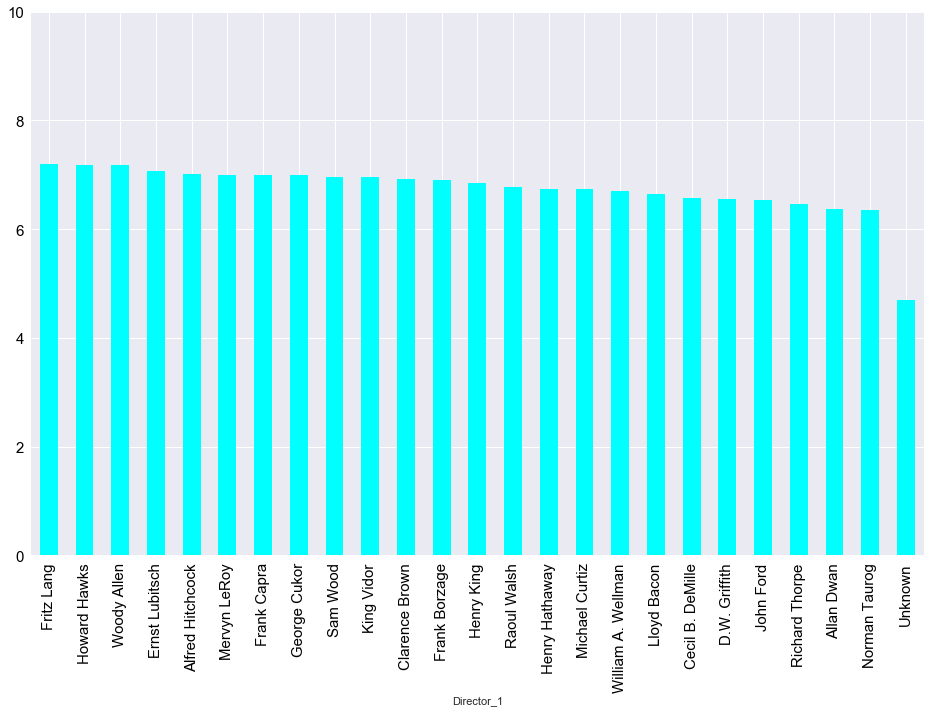

In [782]:
# Plot the 25 most prolific directors and their average rating
ax = director_info.plot('Director_1', 'imdbRating', kind='bar', figsize=(16,10), legend=False, xticks=None,\
                ylim=(0,10), colormap='cool')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

In [582]:
director_count = rated_df['Director_1'].value_counts()
director_count = pd.DataFrame(director_count)
director_count.reset_index(inplace=True)
director_count.columns = ['Director_1', 'Value']

In [583]:
# Break out Directors with at greater than 5 films in our dataset
director_5 = director_count[director_count.Value > 5]
director_5.head()

,Director_1,Value
0,Michael Curtiz,84
1,John Ford,82
2,Raoul Walsh,60
3,Cecil B. DeMille,56
4,Alfred Hitchcock,53


In [773]:
# Directors with highest average rating (at least 6 films)
director_5_rating = pd.merge(director_5, top_directors, how='left')
director_5_rating = director_5_rating.sort_values('imdbRating', ascending=False)
director_5_rating = director_5_rating.head(25)
director_5_rating

,Director_1,Value,imdbRating
577,Masaki Kobayashi,6,8.483333
375,Christopher Nolan,9,8.333333
645,Satyajit Ray,6,8.250000
441,Andrei Tarkovsky,8,8.100000
357,Hayao Miyazaki,10,8.080000
547,Krzysztof Kieslowski,7,8.028571
533,Sergio Leone,7,7.971429
275,Quentin Tarantino,11,7.881818
656,Mario Monicelli,6,7.833333
602,Henri-Georges Clouzot,6,7.816667


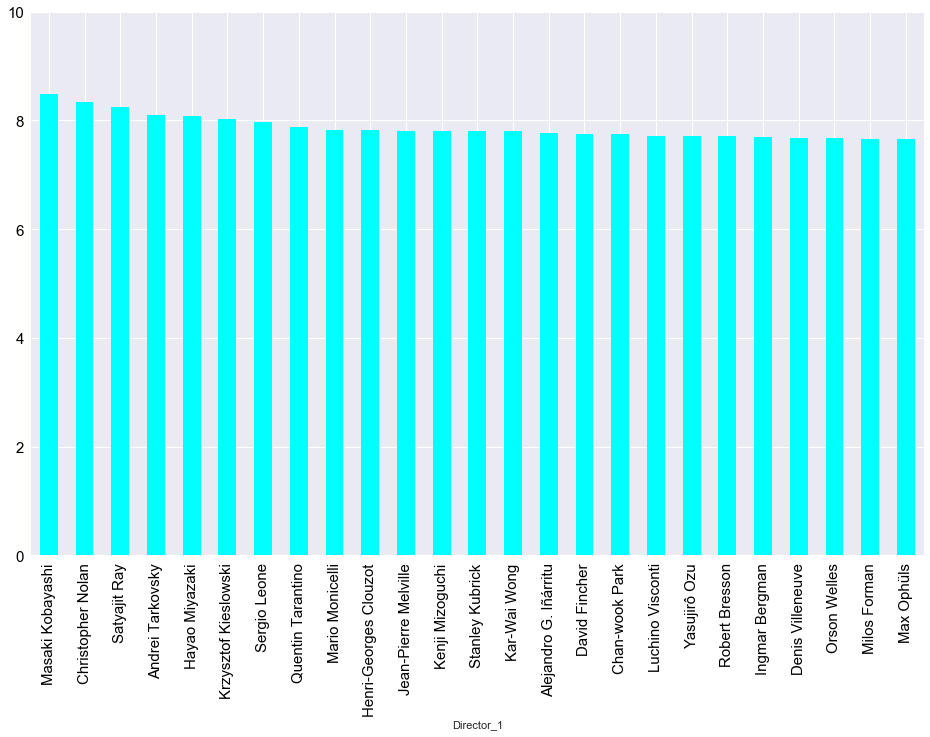

In [775]:
ax = director_5_rating.plot('Director_1', 'imdbRating', kind='bar', figsize=(16,10), legend=False, xticks=None,\
                ylim=(0,10), colormap='cool')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

In [587]:
directors_5up = director_5['Director_1']

In [588]:
len(directors_5up)

658

In [589]:
# Dummy directors with >5 films
for dirc in directors_5up:
    rated_df[dirc] = np.where(rated_df['Director_1']==dirc, 1, 0)

In [590]:
rated_df['Billy Wilder'].sum()

25

### Language

In [591]:
rated_df['Language'].nunique()

959

In [592]:
rated_df['Language_main'] = rated_df['Language'].apply(director)

In [593]:
rated_df['Language_main'].nunique()

58

In [594]:
rated_df['Language_main'].value_counts()[:20]

English       12439
Unknown         672
French          504
Italian         324
German          236
Japanese        186
Spanish         127
Swedish          63
Russian          61
Hindi            56
Mandarin         33
Cantonese        32
Danish           26
Polish           15
Czech            15
Korean           15
Turkish          14
Portuguese       12
Dutch             9
Greek             8
Name: Language_main, dtype: int64

In [595]:
rated_df['Language_main'] = rated_df['Language_main'].str.replace('Unknown','English')

In [596]:
rated_df['Language_main'].value_counts()[:20]

English       13111
French          504
Italian         324
German          236
Japanese        186
Spanish         127
Swedish          63
Russian          61
Hindi            56
Mandarin         33
Cantonese        32
Danish           26
Korean           15
Czech            15
Polish           15
Turkish          14
Portuguese       12
Dutch             9
Hungarian         8
Greek             8
Name: Language_main, dtype: int64

In [598]:
# Dummy Language
language = pd.get_dummies(rated_df['Language_main'], prefix='Lang', prefix_sep='_')
language.head(1)

,Lang_Aboriginal,Lang_Afrikaans,Lang_Albanian,Lang_Arabic,Lang_Aramaic,Lang_Armenian,Lang_Azerbaijani,Lang_Belarusian,Lang_Bengali,Lang_Bulgarian,...,Lang_Somali,Lang_Spanish,Lang_Swedish,Lang_Tagalog,Lang_Tamil,Lang_Thai,Lang_Turkish,Lang_Ukrainian,Lang_Urdu,Lang_Yiddish
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [599]:
# Going to hold off on using language for now, and use country instead

### Rating

In [600]:
rated_df['Rated'] = rated_df['Rated'].str.lower()

In [601]:
rated_df['Rated'].unique()

array([u'approved', u'pg', u'r', u'pg-13', nan, u'g', u'passed', u'tv-g',
       u'not rated', u'unrated', u'm', u'tv-pg', u'gp', u'x', u'nc-17',
       u'tv-ma', u'tv-14'], dtype=object)

In [602]:
rated_df['Rated'].value_counts()

r            3382
approved     2353
pg-13        1548
pg           1464
passed        895
not rated     848
unrated       500
g             327
gp             60
m              52
tv-g           45
nc-17          38
tv-pg          37
x              35
tv-14          11
tv-ma           7
Name: Rated, dtype: int64

In [603]:
rated_df["Year"][rated_df['Rated'] == 'passed'].head(10)

20     1936
22     1935
30     1930
38     1930
40     1940
53     1935
92     1939
117    1938
134    1928
162    1943
Name: Year, dtype: int64

In [604]:
# replace m and gp with pg as those ratings were replaced later on with the pg rating
rated_df['Rated'] = rated_df['Rated'].str.replace('gp','pg')
rated_df['Rated'] = rated_df['Rated'].str.replace('m','pg')
# replace x with nc-17
rated_df['Rated'] = rated_df['Rated'].str.replace('x','nc-17')
# replace unrated with not rated
rated_df['Rated'] = rated_df['Rated'].str.replace('unrated','not rated')
rated_df['Rated'] = rated_df['Rated'].str.replace('passed','approved')

In [605]:
rated_df['Rated'] = rated_df['Rated'].fillna('not rated')

In [606]:
rated_df['Rated'].isnull().sum()

0

In [607]:
rating_dum = rated_df['Rated'].unique()

In [608]:
# Dummy rating
rating = pd.get_dummies(rated_df['Rated'], prefix='Rated', prefix_sep='_')
rating.head(1)

,Rated_approved,Rated_g,Rated_nc-17,Rated_not rated,Rated_pg,Rated_pg-13,Rated_r,Rated_tv-14,Rated_tv-g,Rated_tv-pg,Rated_tv-pga
0,1,0,0,0,0,0,0,0,0,0,0


In [609]:
rated_df = rated_df.merge(rating, how='left', left_index=True, right_index=True)
rated_df.head(1)

,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Rated_g,Rated_nc-17,Rated_not rated,Rated_pg,Rated_pg-13,Rated_r,Rated_tv-14,Rated_tv-g,Rated_tv-pg,Rated_tv-pga
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,approved,...,0,0,0,0,0,0,0,0,0,0


In [610]:
rated_df.columns

Index([         u'Actors',       u'BoxOffice',         u'Country',
              u'Director',           u'Genre',        u'Language',
             u'Metascore',            u'Plot',      u'Production',
                 u'Rated',
       ...
               u'Rated_g',     u'Rated_nc-17', u'Rated_not rated',
              u'Rated_pg',     u'Rated_pg-13',         u'Rated_r',
           u'Rated_tv-14',      u'Rated_tv-g',     u'Rated_tv-pg',
          u'Rated_tv-pga'],
      dtype='object', length=719)

In [611]:
rated_df[rated_df['Rated'] == 'tv-pga'].head(1)

,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Rated_g,Rated_nc-17,Rated_not rated,Rated_pg,Rated_pg-13,Rated_r,Rated_tv-14,Rated_tv-g,Rated_tv-pg,Rated_tv-pga
417,"Julie Christie, Laurence Harvey, Dirk Bogarde,...",NaN,UK,John Schlesinger,"Drama, Romance",English,NaN,A beautiful but amoral model sleeps her way to...,Lionsgate Films,tv-pga,...,0,0,0,0,0,0,0,0,0,1


### Country

In [612]:
rated_df['Country'].nunique()

766

In [613]:
rated_df['Country_Main'] = rated_df['Country'].apply(director)

In [614]:
rated_df['Country_Main'].nunique()

65

In [615]:
rated_df['Country_Main'].value_counts()[:20]

USA             10505
UK               1566
France            653
Italy             437
Germany           270
Japan             208
Canada            154
Australia         127
Spain             105
Sweden             95
West Germany       76
Soviet Union       74
India              73
Denmark            63
Mexico             61
Hong Kong          54
Russia             28
Ireland            26
Unknown            24
Austria            23
Name: Country_Main, dtype: int64

In [616]:
rated_df['Country_Main'] = rated_df['Country_Main'].str.replace('Unknown','USA')

In [617]:
rated_df['Country_Main'].isnull().sum()

0

In [618]:
country_values = rated_df['Country_Main'].value_counts()
country_values = pd.DataFrame(country_values)
country_values.reset_index(inplace=True)
country_values.columns = ['Country_Main', 'Values']
country_values.head()

,Country_Main,Values
0,USA,10529
1,UK,1566
2,France,653
3,Italy,437
4,Germany,270


In [619]:
Top_countries = rated_df[["Country_Main", "imdbRating"]].groupby(['Country_Main'], as_index=False).mean()

In [620]:
country_info = pd.merge(Top_countries, country_values, how='left')

In [768]:
country_40 = country_info.sort_values('Values', ascending=False).head(25)

In [769]:
country_40.sort_values('imdbRating', ascending=False, inplace=True)

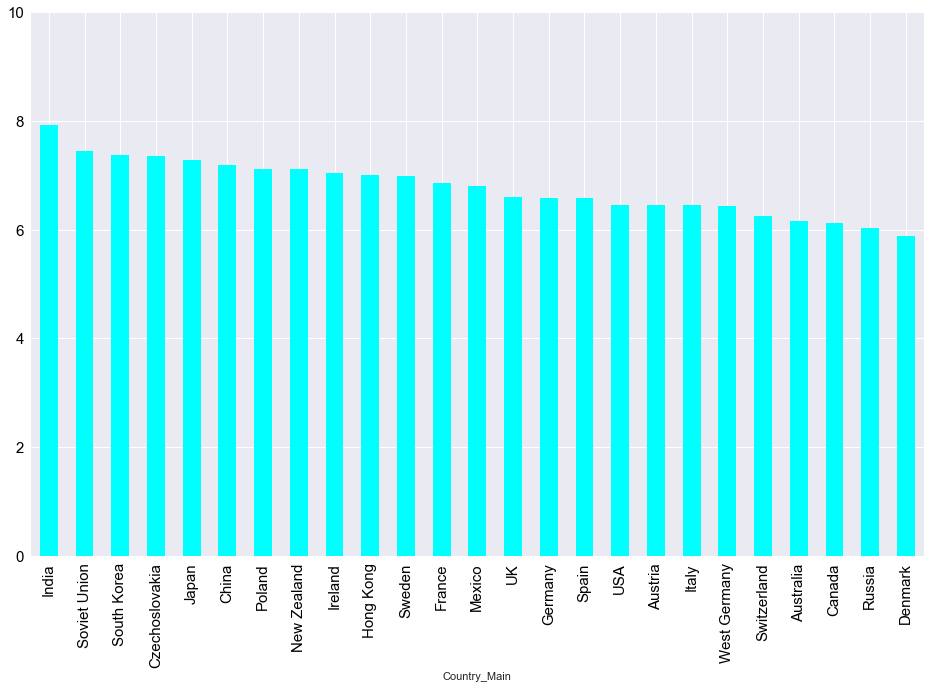

In [772]:
ax = country_40.plot('Country_Main', 'imdbRating', kind='bar', figsize=(16,10), legend=False, xticks=None,\
                ylim=(0,10), colormap='cool')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

In [631]:
country_dummy = rated_df['Country_Main'].value_counts()
country_dummy = pd.DataFrame(country_dummy)
country_dummy = country_dummy[country_dummy.Country_Main > 5]
country_index = country_dummy.index
country_index

Index([u'USA', u'UK', u'France', u'Italy', u'Germany', u'Japan', u'Canada',
       u'Australia', u'Spain', u'Sweden', u'West Germany', u'Soviet Union',
       u'India', u'Denmark', u'Mexico', u'Hong Kong', u'Russia', u'Ireland',
       u'Austria', u'China', u'New Zealand', u'Czechoslovakia', u'Poland',
       u'South Korea', u'Switzerland', u'Netherlands', u'Hungary', u'Turkey',
       u'Argentina', u'Greece', u'Brazil', u'Belgium', u'Norway',
       u'South Africa', u'Yugoslavia', u'Taiwan', u'Finland', u'Portugal',
       u'Iran', u'Philippines'],
      dtype='object')

In [632]:
len(country_index)

40

In [633]:
# Dummy directors with >5 films
for country in country_index:
    rated_df[country] = np.where(rated_df['Country_Main']==country, 1, 0)

In [634]:
rated_df['USA'].sum()

10529

### Production Company

In [635]:
rated_df['Production'].nunique()

1208

In [636]:
rated_df['Production'].isnull().sum()

0

In [637]:
production = pd.DataFrame(rated_df['Production'].value_counts()[:100]).T
production.drop('Unknown', axis=1, inplace=True)
production.head()

,Warner Brothers,20th Century Fox,Paramount Pictures,MGM,Universal Pictures,Sony Pictures,United Artists,Columbia Pictures,The Criterion Collection,MCA Universal,...,Legend Films,FilmDistrict,Drafthouse Films,Rogue Pictures,Jensen Farley Pictures,Associated Film Distribution,Independent International Pictures,Tartan Films,Independent Pictures,ThinkFilm
Production,1416,1103,947,937,726,680,395,376,243,223,...,8,8,7,7,7,7,7,7,7,6


In [638]:
top_production = production.columns

In [639]:
# Dummy directors with >5 films
for prod in top_production:
    rated_df[prod] = np.where(rated_df['Production']==prod, 1, 0)

In [640]:
rated_df['Warner Brothers'].sum()

1416

In [759]:
production_40 = pd.DataFrame(top_production[:25])
production_40.columns = ['Production']

In [760]:
production_ratings = rated_df[["Production", "imdbRating"]].groupby(['Production'], as_index=False).mean()

In [761]:
production_ratings_40 = pd.merge(production_40, production_ratings, how='left')

In [762]:
production_sort = production_ratings_40.sort_values('imdbRating', ascending=False)

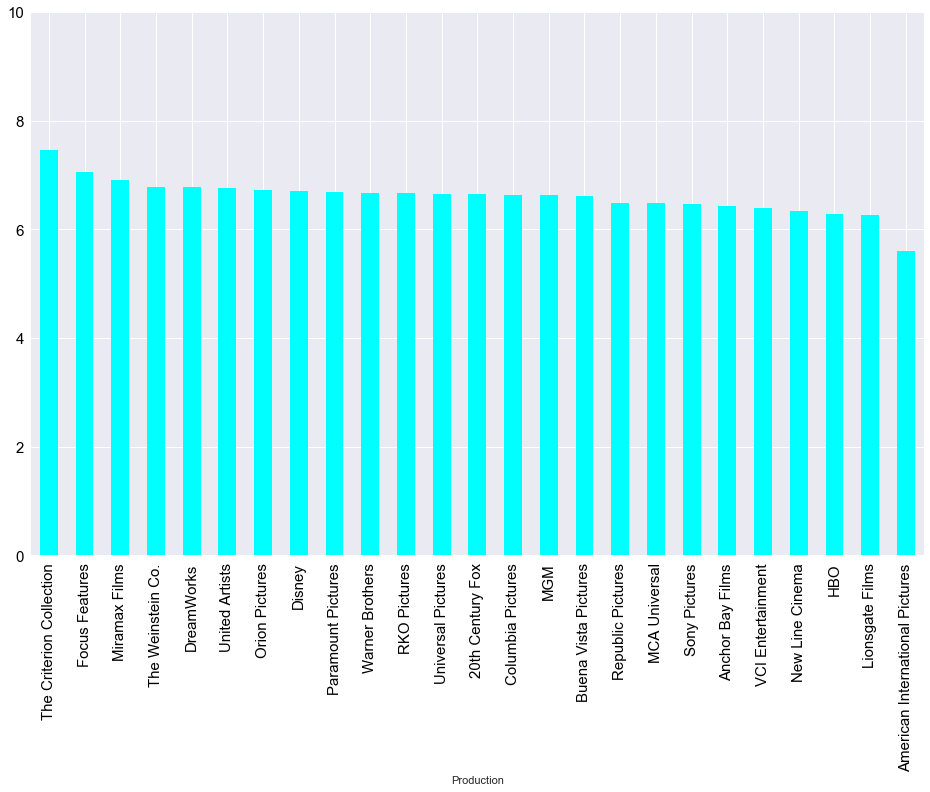

In [764]:
ax = production_sort.plot('Production', 'imdbRating', kind='bar', figsize=(16,10), legend=False, xticks=None,\
                ylim=(0,10), colormap='cool')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

In [765]:
production_all = pd.DataFrame(top_production)
production_all.columns = ['Production']

In [766]:
production_sort = production_ratings.sort_values('imdbRating', ascending=False)

### Actors

In [650]:
rated_df['Actors'].describe()

count                                                 14876
unique                                                14790
top       Roy Rogers, Trigger, George 'Gabby' Hayes, Dal...
freq                                                      6
Name: Actors, dtype: object

In [651]:
rated_df['Actors'].isnull().sum()

61

In [652]:
rated_df['Actors'].fillna(value='None', inplace=True)

In [653]:
rated_df['Actors'].isnull().sum()

0

In [654]:
# Countvectorize actors

In [655]:
def grams_per_comma(string):
    for ln in string.split(','):
        terms = re.findall(r'\w{2,}', ln)
        for gram in zip(terms, terms[1:]):
            yield '%s %s' % gram

In [656]:
from sklearn.feature_extraction.text import CountVectorizer

In [657]:
cvec = CountVectorizer(analyzer=grams_per_comma, ngram_range=(3, 3), max_features=100)
cvec.fit(rated_df['Actors'])

CountVectorizer(analyzer=<function grams_per_comma at 0x132e527d0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=100, min_df=1, ngram_range=(3, 3), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)

In [658]:
actors_df  = pd.DataFrame(cvec.transform(rated_df['Actors']).todense(),
             columns=cvec.get_feature_names())

actors = actors_df.transpose().sort_values(0, ascending=False).transpose()
print actors.shape
actors.head()

(14937, 100)


,Adolphe Menjou,Lionel Barrymore,Nicolas Cage,Myrna Loy,Michael Caine,Meryl Streep,Melvyn Douglas,Maureen Hara,Mary Pickford,Marlon Brando,...,Fred MacMurray,Frank Sinatra,Frank Morgan,Franchot Tone,Errol Flynn,Elizabeth Taylor,Edward Robinson,Douglas Fairbanks,Doris Day,William Powell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [659]:
actors_columns = []
for i in actors.columns:
    name = i+'_Actor'
    actors_columns.append(name)

In [660]:
actors.columns = actors_columns
actors.head(1)

,Adolphe Menjou_Actor,Lionel Barrymore_Actor,Nicolas Cage_Actor,Myrna Loy_Actor,Michael Caine_Actor,Meryl Streep_Actor,Melvyn Douglas_Actor,Maureen Hara_Actor,Mary Pickford_Actor,Marlon Brando_Actor,...,Fred MacMurray_Actor,Frank Sinatra_Actor,Frank Morgan_Actor,Franchot Tone_Actor,Errol Flynn_Actor,Elizabeth Taylor_Actor,Edward Robinson_Actor,Douglas Fairbanks_Actor,Doris Day_Actor,William Powell_Actor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [661]:
merge_df = rated_df.merge(actors, how='left', left_index=True, right_index=True)
print merge_df.shape
merge_df.head(1)

(14937, 959)


,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Fred MacMurray_Actor,Frank Sinatra_Actor,Frank Morgan_Actor,Franchot Tone_Actor,Errol Flynn_Actor,Elizabeth Taylor_Actor,Edward Robinson_Actor,Douglas Fairbanks_Actor,Doris Day_Actor,William Powell_Actor
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,approved,...,0,0,0,0,0,0,0,0,0,0


### Plot

In [662]:
rated_df['Plot'].fillna('None',inplace=True)

In [663]:
cvec = CountVectorizer(stop_words='english', max_features=40)
cvec.fit(rated_df['Plot'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=40, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [664]:
plot_tdf  = pd.DataFrame(cvec.transform(rated_df['Plot']).todense(),
             columns=cvec.get_feature_names())

plot_feats = plot_tdf.transpose().sort_values(0, ascending=False).transpose()
plot_feats.head()

,world,american,time,new,old,school,small,son,story,takes,...,gets,love,girl,group,help,home,husband,life,lives,young
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1


In [665]:
plot_columns = []
for i in plot_feats.columns:
    name = 'Plot_'+i
    plot_columns.append(name)

In [666]:
plot_feats.columns = plot_columns
plot_feats.head()

,Plot_world,Plot_american,Plot_time,Plot_new,Plot_old,Plot_school,Plot_small,Plot_son,Plot_story,Plot_takes,...,Plot_gets,Plot_love,Plot_girl,Plot_group,Plot_help,Plot_home,Plot_husband,Plot_life,Plot_lives,Plot_young
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1


In [667]:
plot_feats.shape

(14937, 40)

In [668]:
plot_feats['Plot_american'].sum()

547

In [669]:
merge_df = merge_df.merge(plot_feats, how='left', left_index=True, right_index=True)
print merge_df.shape
merge_df.head(1)

(14937, 999)


,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Plot_gets,Plot_love,Plot_girl,Plot_group,Plot_help,Plot_home,Plot_husband,Plot_life,Plot_lives,Plot_young
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,approved,...,0,0,0,0,0,0,0,0,0,0


### Title

In [670]:
cvec_t = CountVectorizer(stop_words='english', max_features=40)
cvec_t.fit(rated_df['Title'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=40, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [671]:
title_df  = pd.DataFrame(cvec_t.transform(rated_df['Title']).todense(),
             columns=cvec_t.get_feature_names())

title = title_df.transpose().sort_values(0, ascending=False).transpose()
print title.shape
title.head()

(14937, 40)


,adventures,american,little,love,man,men,mr,new,night,red,...,death,king,devil,die,girl,girls,great,house,ii,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [672]:
title_columns = []
for i in title.columns:
    name = 'Title_'+i
    title_columns.append(name)

In [673]:
title.columns = title_columns
title.head()

,Title_adventures,Title_american,Title_little,Title_love,Title_man,Title_men,Title_mr,Title_new,Title_night,Title_red,...,Title_death,Title_king,Title_devil,Title_die,Title_girl,Title_girls,Title_great,Title_house,Title_ii,Title_young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [674]:
merge_df = merge_df.merge(title, how='left', left_index=True, right_index=True)
print merge_df.shape
merge_df.head(1)

(14937, 1039)


,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Title_death,Title_king,Title_devil,Title_die,Title_girl,Title_girls,Title_great,Title_house,Title_ii,Title_young
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,approved,...,0,0,0,0,0,0,0,0,0,0


### Producers

In [675]:
producers = pd.read_pickle('producer_df.pkl')

In [676]:
# Define a function to grab to first Director for each feature
def producer(listy):
    try:
        return listy[0] 
    except:
        return 'None'

In [677]:
producers['Producer_1'] = producers['Producers'].apply(producer)

In [678]:
producer_clean = producers.drop('Producers', axis=1)
producer_clean.head()

,imdbID,Producer_1
0,tt0437222,None
1,tt0050210,Jacques R. Marquette
2,tt0030725,George M. Merrick
3,tt0050212,Sam Spiegel
4,tt0381681,Isabelle Coulet


In [679]:
top_producers = producer_clean['Producer_1'].value_counts()[:100]

In [680]:
top_producers = pd.DataFrame(top_producers)
top_producers.reset_index(inplace=True)
top_producers = top_producers.iloc[1:,:]
top_producers_list = top_producers['index'].tolist()
# top_producers_list

[u'Samuel Goldwyn',
 u'Pandro S. Berman',
 u'Cecil B. DeMille',
 u'Samuel Z. Arkoff',
 u'Henry Blanke',
 u'Bruce Berman',
 u'Michael Balcon',
 u'Tim Bevan',
 u'Hal B. Wallis',
 u'Samuel Bischoff',
 u'Gary Barber',
 u'Hunt Stromberg',
 u'Joe Pasternak',
 u'Dino De Laurentiis',
 u'William LeBaron',
 u'Jesse L. Lasky',
 u'Erich Pommer',
 u'D.W. Griffith',
 u'Yoram Globus',
 u'Harry Joe Brown',
 u'Darryl F. Zanuck',
 u'Thomas H. Ince',
 u'Roger Corman',
 u'Jerry Wald',
 u'Arthur Freed',
 u'William Fox',
 u'Sol C. Siegel',
 u'David O. Selznick',
 u'Robert Arthur',
 u'Barry Bernardi',
 u'Jack Cummings',
 u'Jerry Bruckheimer',
 u'William Perlberg',
 u'Edmund Grainger',
 u'Fred Kohlmar',
 u'Carl Laemmle Jr.',
 u'Sol M. Wurtzel',
 u'B.P. Schulberg',
 u'Nunnally Johnson',
 u'Arthur Hornblow Jr.',
 u'Paul Malvern',
 u'Irving Thalberg',
 u'Aaron Rosenberg',
 u'Michael Carreras',
 u'Ross Hunter',
 u'Walt Disney',
 u'Walter Wanger',
 u'Kenneth Macgowan',
 u'Robert Greenhut',
 u'Judd Apatow',
 u'Doug

In [681]:
# Dummy directors with >5 films
for prod in top_producers_list:
    producer_clean[prod+'_Producer'] = np.where(producer_clean['Producer_1']==prod, 1, 0)

In [682]:
producer_clean.head()

,imdbID,Producer_1,Samuel Goldwyn_Producer,Pandro S. Berman_Producer,Cecil B. DeMille_Producer,Samuel Z. Arkoff_Producer,Henry Blanke_Producer,Bruce Berman_Producer,Michael Balcon_Producer,Tim Bevan_Producer,...,Albert R. Broccoli_Producer,Paul Davidson_Producer,Edward Small_Producer,Louis D. Lighton_Producer,Raymond Griffith_Producer,Luc Besson_Producer,Nat Levine_Producer,Sol Lesser_Producer,William Goetz_Producer,Raymond Hakim_Producer
0,tt0437222,None,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0050210,Jacques R. Marquette,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0030725,George M. Merrick,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0050212,Sam Spiegel,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0381681,Isabelle Coulet,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [685]:
producer_clean['Samuel Goldwyn_Producer'].sum()

79

In [686]:
# Merge producer_1
merge_df = pd.merge(merge_df, producer_clean, how='left')
print merge_df.shape
merge_df.head(1)

(14937, 1139)


,Actors,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,...,Albert R. Broccoli_Producer,Paul Davidson_Producer,Edward Small_Producer,Louis D. Lighton_Producer,Raymond Griffith_Producer,Luc Besson_Producer,Nat Levine_Producer,Sol Lesser_Producer,William Goetz_Producer,Raymond Hakim_Producer
0,"John Agar, Joyce Meadows, Robert Fuller, Thoma...",NaN,USA,Nathan Juran,"Action, Adventure, Horror",English,NaN,"Gor, a powerful criminal brain from the planet...",Howco International Pictures,approved,...,0,0,0,0,0,0,0,0,0,0


### Box Office

In [687]:
gross = pd.read_pickle('gross_perf.pkl')

In [688]:
gross.reset_index(drop=True, inplace=True)
gross.head()

,imdbID,Budget,Gross,performance
0,tt0050210,58000.0,NaN,NaN
1,tt0050212,3000000.0,5668000.0,0.889333
2,tt0381681,2700000.0,5792822.0,1.145490
3,tt0472160,15000000.0,10011274.0,-0.332582
4,tt0209475,35000000.0,94728529.0,1.706529


In [689]:
gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 4 columns):
imdbID         7701 non-null object
Budget         6069 non-null float64
Gross          6433 non-null float64
performance    4801 non-null float64
dtypes: float64(3), object(1)
memory usage: 240.7+ KB


In [690]:
# Only 4800 films with info for both gross and budget
# Performance is a measure of how well a film did in the box office in relation to its budget
# Will subset the data later and run another model using performance

---

In [691]:
merge_df.to_pickle('merged_cleaned.pkl')

In [692]:
merge_df = pd.read_pickle('merged_cleaned.pkl')

In [693]:
merge_df.columns

Index([                     u'Actors',                   u'BoxOffice',
                           u'Country',                    u'Director',
                             u'Genre',                    u'Language',
                         u'Metascore',                        u'Plot',
                        u'Production',                       u'Rated',
       ...
       u'Albert R. Broccoli_Producer',      u'Paul Davidson_Producer',
             u'Edward Small_Producer',   u'Louis D. Lighton_Producer',
         u'Raymond Griffith_Producer',         u'Luc Besson_Producer',
               u'Nat Levine_Producer',         u'Sol Lesser_Producer',
            u'William Goetz_Producer',      u'Raymond Hakim_Producer'],
      dtype='object', length=1139)

In [694]:
merge_df.shape

(14937, 1139)

In [696]:
merge_df['Nat Levine_Producer'].sum()

16

In [697]:
merge_df.isnull().sum()

Actors                                0
BoxOffice                         12839
Country                              24
Director                             41
Genre                               187
Language                            672
Metascore                         11395
Plot                                749
Production                            0
Rated                                 0
Released                            408
Title                                 0
Writer                              139
Year                                  0
imdbID                                0
imdbRating                            0
imdbVotes                             6
Release_Date                        408
Month                               408
Oscar_wins                            0
Oscar_noms                            0
Award_wins                            0
Award_noms                            0
RunTime                               0
genre_1                               0


In [698]:
drop = [u'Actors', u'BoxOffice', u'Country', u'Director',
        u'Genre', u'Language', u'Plot',
        u'Production', 'Released', 'Title', 'Writer',
        'Release_Date']

In [699]:
df = merge_df.drop(drop, axis=1)

In [700]:
# Fill votes with the mdeian for the rating
df.imdbVotes.fillna(df.groupby(["imdbRating"])["imdbVotes"].transform("median"), inplace=True)

In [701]:
# Fill month with the mode
df.Month.fillna(df.Month.mode()[0], inplace=True)

In [702]:
df.isnull().sum()

Metascore                         11395
Rated                                 0
Year                                  0
imdbID                                0
imdbRating                            0
imdbVotes                             0
Month                                 0
Oscar_wins                            0
Oscar_noms                            0
Award_wins                            0
Award_noms                            0
RunTime                               0
genre_1                               0
genre_2                               0
genre_3                               0
Action                                0
Adventure                             0
Animation                             0
Biography                             0
Comedy                                0
Crime                                 0
Drama                                 0
Family                                0
Fantasy                               0
Film-Noir                             0


In [327]:
# df.fillna(0, inplace=True)

In [703]:
# df.isnull().sum()

In [704]:
import seaborn as sns

In [705]:
# Create a list of quantitative data columns
quant = ['imdbRating',
         'imdbVotes',
         'Year',
         'Month',
         'RunTime']
quant

['imdbRating', 'imdbVotes', 'Year', 'Month', 'RunTime']

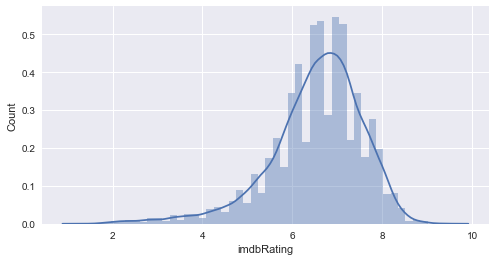

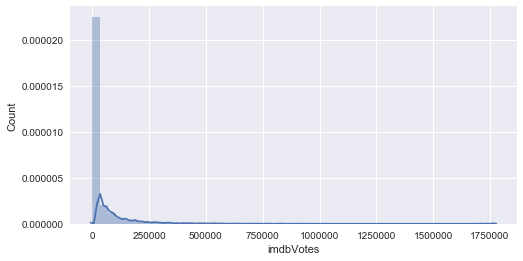

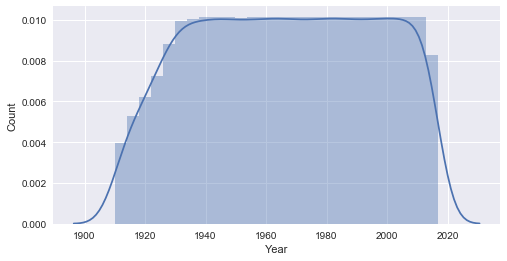

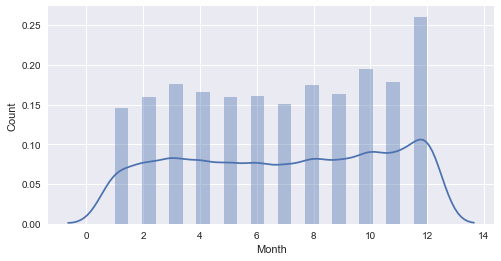

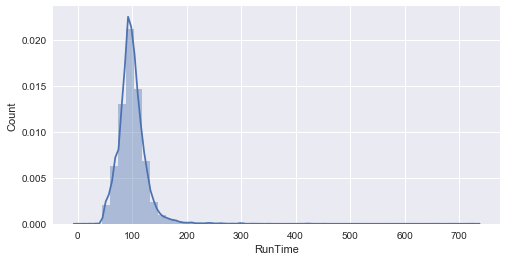

In [706]:
# Plot Histograms of numerical data columns
sns.set(rc={"figure.figsize": (8, 4)})
for i in quant:
    sns.distplot(df[i])
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.show()

In [707]:
df['imdbRating'].describe(percentiles=[.25,.33,.66, .75])

count    14937.000000
mean         6.528560
std          1.041723
min          1.300000
25%          6.000000
33%          6.200000
50%          6.700000
66%          7.000000
75%          7.200000
max          9.500000
Name: imdbRating, dtype: float64

In [708]:
# Bin rating into high, mid, low (3,2,1)

In [709]:
rating_labels = []
for i in df['imdbRating']:
    if i >= 7.2:
        rate = 2
    elif i >= 6.2:
        rate = 1
    else:
        rate = 0
    rating_labels.append(rate)

In [710]:
df['Rating_Labels'] = rating_labels

In [711]:
df.iloc[:,:15].head(1)

,Metascore,Rated,Year,imdbID,imdbRating,imdbVotes,Month,Oscar_wins,Oscar_noms,Award_wins,Award_noms,RunTime,genre_1,genre_2,genre_3
0,NaN,approved,1957,tt0050210,5.3,1109.0,10.0,0,0,0,0,71.0,Action,Adventure,Horror


In [712]:
drop_for_sklearn = ['Rated', 'imdbID', 'imdbRating', 'genre_1', 'genre_2', 'genre_3',\
                   u'Director_1',u'Language_main',u'Country_Main', 'Producer_1',]

In [713]:
df.imdbVotes = df.imdbVotes.apply(int)

In [714]:
df.to_pickle('df.pkl')

In [715]:
df_1 = df.drop(drop_for_sklearn, axis=1)

In [716]:
df_1.columns

Index([                u'Metascore',                      u'Year',
                       u'imdbVotes',                     u'Month',
                      u'Oscar_wins',                u'Oscar_noms',
                      u'Award_wins',                u'Award_noms',
                         u'RunTime',                    u'Action',
       ...
          u'Paul Davidson_Producer',     u'Edward Small_Producer',
       u'Louis D. Lighton_Producer', u'Raymond Griffith_Producer',
             u'Luc Besson_Producer',       u'Nat Levine_Producer',
             u'Sol Lesser_Producer',    u'William Goetz_Producer',
          u'Raymond Hakim_Producer',             u'Rating_Labels'],
      dtype='object', length=1118)

In [717]:
df_1.to_pickle('df_1.pkl')

In [718]:
df_1.head()

,Metascore,Year,imdbVotes,Month,Oscar_wins,Oscar_noms,Award_wins,Award_noms,RunTime,Action,...,Paul Davidson_Producer,Edward Small_Producer,Louis D. Lighton_Producer,Raymond Griffith_Producer,Luc Besson_Producer,Nat Levine_Producer,Sol Lesser_Producer,William Goetz_Producer,Raymond Hakim_Producer,Rating_Labels
0,NaN,1957,1109,10.0,0,0,0,0,71.0,1,...,0,0,0,0,0,0,0,0,0,0
1,NaN,1938,159,3.0,0,0,0,0,300.0,1,...,0,0,0,0,0,0,0,0,0,0
2,NaN,1957,156900,12.0,7,0,23,7,161.0,0,...,0,0,0,0,0,0,0,0,0,2
3,90.0,2004,175947,7.0,0,1,9,27,80.0,0,...,0,0,0,0,0,0,0,0,0,2
4,48.0,2006,52218,2.0,0,0,0,0,104.0,0,...,0,0,0,0,0,0,0,0,0,1


In [719]:
# Check correlations
corr=df_1.corr()["Rating_Labels"]
corr = corr[np.argsort(corr, axis=0)[::-1]]
corr = pd.DataFrame(corr)

In [720]:
# Check correlations
corr=df_1.corr()["Rating_Labels"]
corr = pd.DataFrame(corr)

In [721]:
corr.head()

,Rating_Labels
Metascore,0.704207
Year,-0.026803
imdbVotes,0.213525
Month,0.018392
RunTime,0.265815


In [722]:
corr.sort_values('Rating_Labels', ascending=False, inplace=True, kind='quicksort')

In [723]:
corr.drop('Rating_Labels', inplace=True)

In [724]:
corr.head()

,Rating_Labels
Metascore,0.704207
RunTime,0.265815
imdbVotes,0.213525
Drama,0.143538
The Criterion Collection,0.118982


In [755]:
corr_top_40 = corr.head(25)

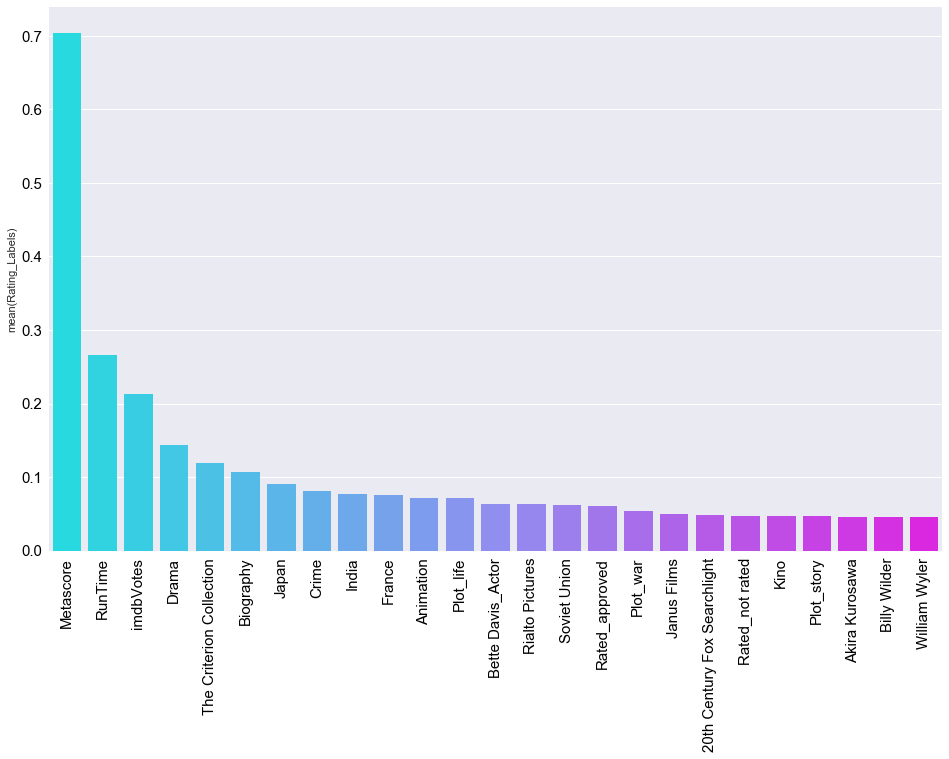

In [757]:
# plot correlations
plt.figure(figsize=(16,10))
ax = sns.barplot(data=corr_top_40, x=corr_top_40.index, y=corr_top_40['Rating_Labels'], palette='cool')
# plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

In [743]:
corr_bot_40 = corr.tail(25)

In [744]:
corr_bot_40

,Rating_Labels
Russ Meyer,-0.033398
Sam Newfield,-0.035283
Burt Reynolds_Actor,-0.036350
New World Pictures,-0.036359
Title_girls,-0.036702
Bert I. Gordon,-0.036853
Robert N. Bradbury,-0.036924
Canada,-0.038265
Title_ii,-0.039315
Crown International Pictures,-0.041253


In [745]:
df_1['Plot_woman'].sum()

1048

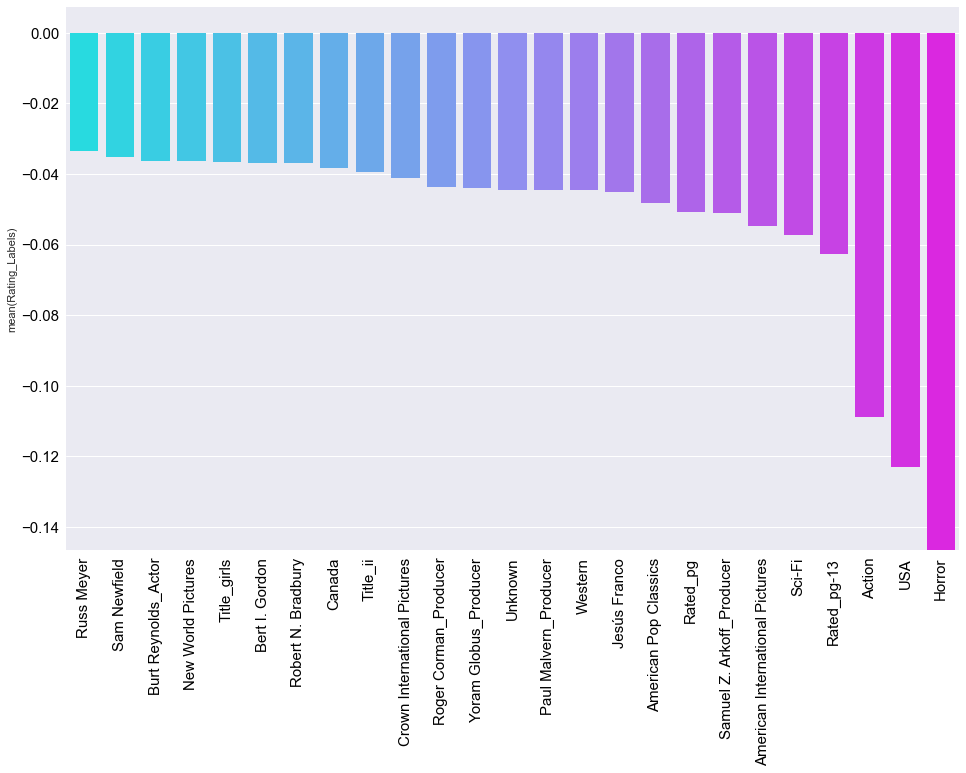

In [754]:
# plot correlations of bottom end
plt.figure(figsize=(16,10))
ax = sns.barplot(data=corr_bot_40, x=corr_bot_40.index, y=corr_bot_40['Rating_Labels'], palette='cool')
# plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='both', which='major', labelsize=15, direction='in', color='w', labelcolor='k')
plt.show()

---
## Models

In [ ]:
# df_meta = df_1.dropna()
# dropped = ['Rating_Labels']
# X1 = df_meta.drop(dropped, axis=1)
# y1 = df_meta['Rating_Labels']

In [795]:
# dropped = ['Rating_Labels']
dropped = ['Rating_Labels', 'Metascore']
X1 = df_1.drop(dropped, axis=1)
y1 = df_1['Rating_Labels']

In [796]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [797]:
# dt = DecisionTreeClassifier()
bc = BaggingClassifier(dt)
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
xt = ExtraTreesClassifier(n_estimators=1000, class_weight='balanced')

def score(model, string):
    s = cross_val_score(model, X1, y1, cv=cv)
    print("{} Score:\t{:0.3} ± {:0.3}".format(string, s.mean().round(3), s.std().round(3)))

In [798]:
score(bc, 'Bagging')

Bagging Score:	0.627 ± 0.003


In [799]:
score(rf, 'Random')

Random Score:	0.642 ± 0.006


In [800]:
score(xt, 'Extra Trees')

Extra Trees Score:	0.605 ± 0.008


In [785]:
# X = X.fillna(method='ffill')

In [801]:
rf = RandomForestClassifier(n_estimators=500, max_depth = 5, class_weight='balanced')
model = rf.fit(X1, y1)

In [802]:
# feature importances 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X1.columns,
                                    columns=['importance'])
importances = feature_importances.sort_values(by='importance', ascending=False).head(40).T
importances

,Award_wins,imdbVotes,Award_noms,RunTime,Oscar_wins,Oscar_noms,Year,Horror,Drama,USA,...,Unknown,Western,Paramount Pictures,Kino,Janus Films,Plot_story,Jesús Franco,Rated_r,Akira Kurosawa,Yoram Globus_Producer
importance,0.092725,0.085929,0.085124,0.073238,0.071699,0.069599,0.040007,0.036774,0.034403,0.034069,...,0.003644,0.003341,0.0033,0.003254,0.002971,0.002786,0.002743,0.00265,0.002602,0.002572


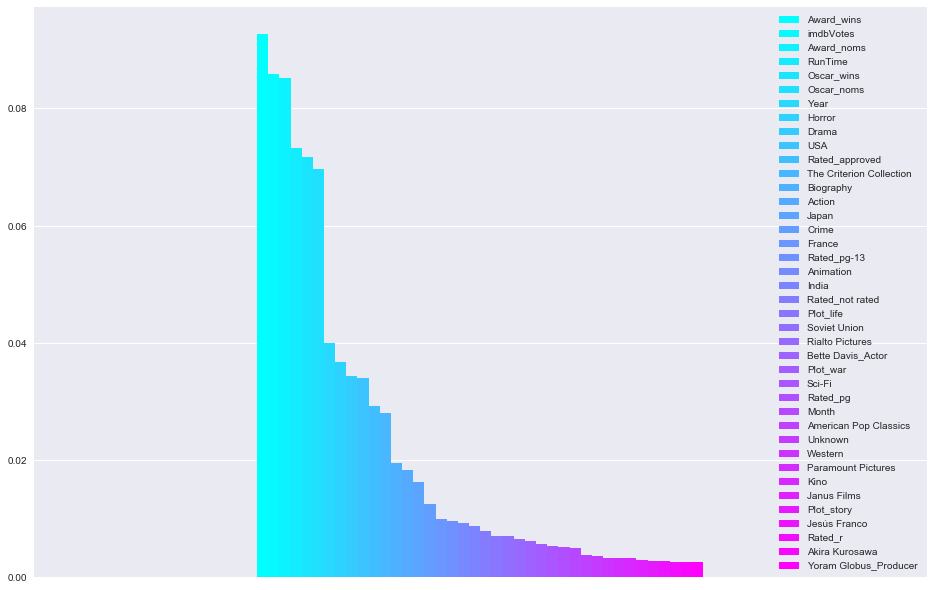

In [805]:
fig, ax = plt.subplots(figsize=(16,10.5))
importances.plot(kind='bar', ax=ax, colormap='cool')
# ax.set_title('Feature Importances', fontsize=20, y=1.01)
ax.get_xaxis().set_visible(False)

In [804]:
importances_x = feature_importances.sort_values(by='importance', ascending=True).head(40).T
importances_x

,Franco Zeffirelli,Melville Shavelson,John Francis Dillon,Bruce Beresford,Curtis Hanson,Jack Cardiff,Kenneth Branagh,Sam Taylor,Kathryn Bigelow,John Emerson,...,Frank R. Strayer,Todd Phillips,Hal Walker,John Hughes,Sergio Martino,Charles Brabin,Harold Ramis,Frank Coraci,Zoltan Korda,Albert S. Rogell
importance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
pred = model.predict(X)

In [367]:
from sklearn.metrics import confusion_matrix, classification_report


# conf matrix
cm = confusion_matrix(y, pred)
cm = pd.DataFrame(cm, columns=["Predict Low Rating", "Predict Average Rating", "Predict High Rating"], \
                  index=["Low Rating", "Average Rating", "High Rating"] )
cm


,Predict Low Rating,Predict Average Rating,Predict High Rating
Low Rating,3466,546,392
Average Rating,2790,2002,1552
High Rating,759,688,2742


In [370]:
class_re = classification_report(y, pred)
print class_re

             precision    recall  f1-score   support

          0       0.49      0.79      0.61      4404
          1       0.62      0.32      0.42      6344
          2       0.59      0.65      0.62      4189

avg / total       0.57      0.55      0.53     14937



In [365]:
rf2 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model2 = rf2.fit(X, y)

In [371]:
# feature importances 

feature_importances2 = pd.DataFrame(rf2.feature_importances_,
                                   index = X.columns,
                                    columns=['importance'])
importances2 = feature_importances2.sort_values(by='importance', ascending=False).head(40).T
importances2

,Award_wins,imdbVotes,RunTime,Award_noms,Oscar_noms,Oscar_wins,Year,USA,Horror,Drama,...,Western,20th Century Fox Searchlight,Akira Kurosawa,American Pop Classics,Unknown,Crown International Pictures,Jesús Franco,Paul Malvern,François Truffaut,William Wyler
importance,0.10166,0.091964,0.087773,0.086465,0.062378,0.059988,0.045569,0.036251,0.036015,0.029969,...,0.00328,0.003239,0.002997,0.002903,0.002718,0.002652,0.002632,0.002575,0.002525,0.002513


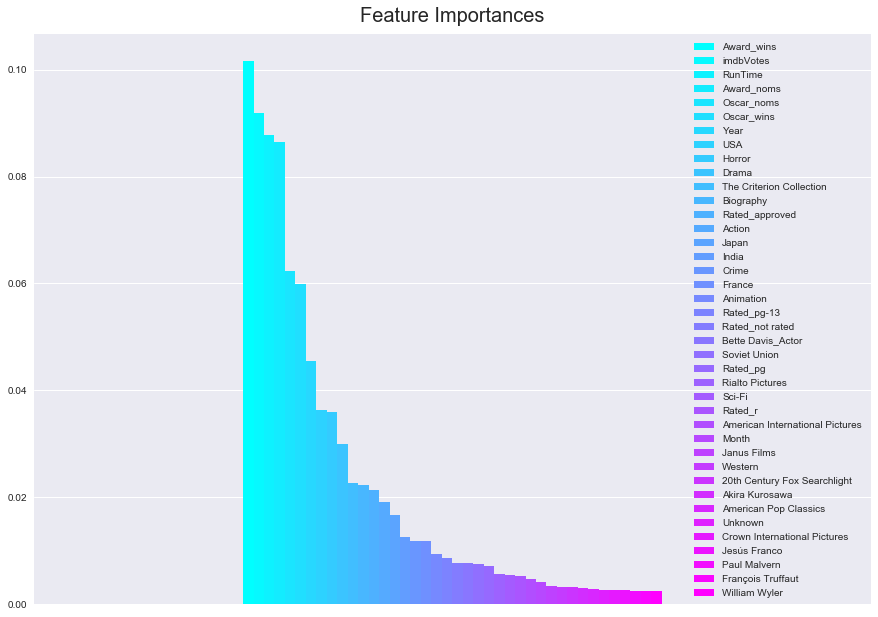

In [372]:
fig, ax = plt.subplots(figsize=(15,10.5))
importances2.plot(kind='bar', ax=ax, colormap='cool')
ax.set_title('Feature Importances', fontsize=20, y=1.01)
ax.get_xaxis().set_visible(False)

---

In [ ]:
# Bring back box office info and rerun

In [376]:
gross.head()

,imdbID,Budget,Gross,performance
0,tt0050210,58000.0,NaN,NaN
1,tt0050212,3000000.0,5668000.0,0.889333
2,tt0381681,2700000.0,5792822.0,1.145490
3,tt0472160,15000000.0,10011274.0,-0.332582
4,tt0209475,35000000.0,94728529.0,1.706529


In [377]:
performance = gross.drop(['Budget','Gross'], axis=1)

In [379]:
performance.dropna(inplace=True)

In [380]:
performance.head()

,imdbID,performance
1,tt0050212,0.889333
2,tt0381681,1.145490
3,tt0472160,-0.332582
4,tt0209475,1.706529
5,tt0871426,1.008978


In [382]:
df_2 = pd.merge(df, performance, how='left')

In [384]:
df_2.dropna(inplace=True)

In [387]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 2 to 14936
Columns: 1116 entries, Rated to performance
dtypes: float64(131), int64(940), object(13), uint8(32)
memory usage: 39.8+ MB


In [388]:
df_2.reset_index(inplace=True, drop=True)

In [392]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792 entries, 0 to 4791
Columns: 1116 entries, Rated to performance
dtypes: float64(131), int64(940), object(13), uint8(32)
memory usage: 39.8+ MB


In [394]:
df_2.columns

Index([           u'Rated',             u'Year',           u'imdbID',
             u'imdbRating',        u'imdbVotes',            u'Month',
             u'Oscar_wins',       u'Oscar_noms',       u'Award_wins',
             u'Award_noms',
       ...
          u'Paul Davidson',     u'Edward Small', u'Louis D. Lighton',
       u'Raymond Griffith',       u'Nat Levine',       u'Sol Lesser',
          u'William Goetz',    u'Raymond Hakim',    u'Rating_Labels',
            u'performance'],
      dtype='object', length=1116)

In [395]:
df_2 = df_2.drop(drop_for_sklearn, axis=1)

In [398]:
df_2.drop('imdbVotes', inplace=True, axis=1)

In [399]:
df_2.columns

Index([            u'Year',            u'Month',       u'Oscar_wins',
             u'Oscar_noms',       u'Award_wins',       u'Award_noms',
                u'RunTime',           u'Action',        u'Adventure',
              u'Animation',
       ...
          u'Paul Davidson',     u'Edward Small', u'Louis D. Lighton',
       u'Raymond Griffith',       u'Nat Levine',       u'Sol Lesser',
          u'William Goetz',    u'Raymond Hakim',    u'Rating_Labels',
            u'performance'],
      dtype='object', length=1105)

In [401]:
dropped = ['Rating_Labels']
X = df_2.drop(dropped, axis=1)
y = df_2['Rating_Labels']

In [402]:
dt = DecisionTreeClassifier()
bc = BaggingClassifier(dt)
rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
xt = ExtraTreesClassifier(n_estimators=1000, class_weight='balanced')

def score(model, string):
    s = cross_val_score(model, X, y, cv=cv)
    print("{} Score:\t{:0.3} ± {:0.3}".format(string, s.mean().round(3), s.std().round(3)))

In [404]:
rf3 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model = rf3.fit(X, y)

In [417]:
# feature importances 

feature_importances3 = pd.DataFrame(rf3.feature_importances_,
                                   index = X.columns,
                                    columns=['importance'])
importances3 = feature_importances3.sort_values(by='importance', ascending=False).head(40).T
importances3

,Award_wins,Award_noms,RunTime,Oscar_wins,Oscar_noms,performance,Year,Drama,Action,Biography,...,Stanley Kubrick,Walt Disney,Media Home Entertainment,MCA Universal,Christopher Nolan,Quentin Tarantino,Rialto Pictures,Peter Jackson,Albert R. Broccoli,Hollywood Pictures
importance,0.127965,0.103884,0.092063,0.090204,0.062128,0.053036,0.040108,0.030653,0.027022,0.023237,...,0.003152,0.003102,0.002966,0.002747,0.002595,0.002562,0.002196,0.002042,0.001893,0.00187


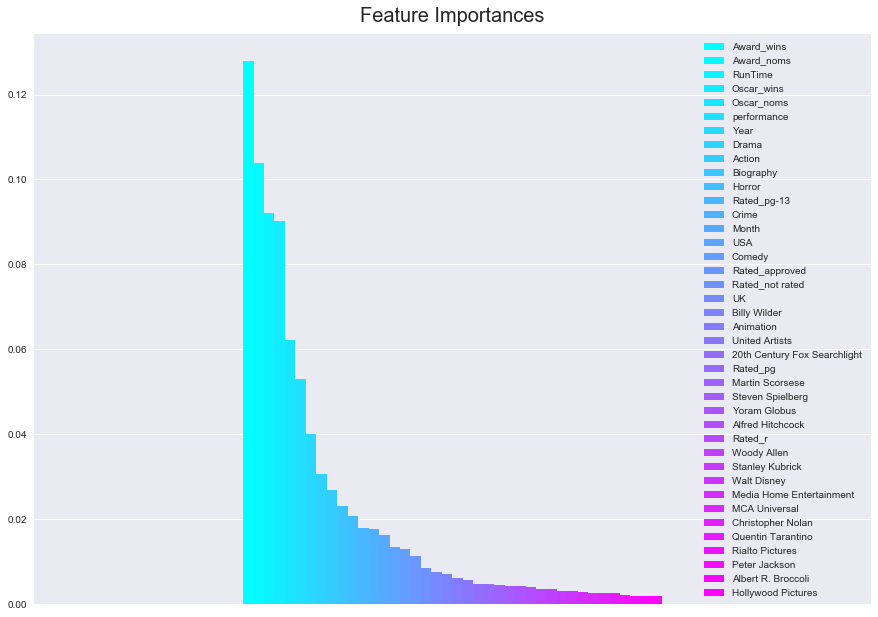

In [418]:
fig, ax = plt.subplots(figsize=(15,10.5))
importances3.plot(kind='bar', ax=ax, colormap='cool')
ax.set_title('Feature Importances', fontsize=20, y=1.01)
ax.get_xaxis().set_visible(False)

In [407]:
pred = model.predict(X)

In [408]:
# conf matrix
cm = confusion_matrix(y, pred)
cm = pd.DataFrame(cm, columns=["Predict Low Rating", "Predict Average Rating", "Predict High Rating"], \
                  index=["Low Rating", "Average Rating", "High Rating"] )
cm

,Predict Low Rating,Predict Average Rating,Predict High Rating
Low Rating,1198,110,86
Average Rating,942,546,470
High Rating,196,178,1066


In [409]:
class_re = classification_report(y, pred)
print class_re

             precision    recall  f1-score   support

          0       0.51      0.86      0.64      1394
          1       0.65      0.28      0.39      1958
          2       0.66      0.74      0.70      1440

avg / total       0.61      0.59      0.56      4792



---

In [410]:
dropped = ['Award_wins', 'Award_noms', 'Oscar_wins', 'Oscar_noms', 'Year','RunTime']
df_3 = df_2.drop(dropped, axis=1)

In [412]:
df_3.columns

Index([           u'Month',           u'Action',        u'Adventure',
              u'Animation',        u'Biography',           u'Comedy',
                  u'Crime',            u'Drama',           u'Family',
                u'Fantasy',
       ...
          u'Paul Davidson',     u'Edward Small', u'Louis D. Lighton',
       u'Raymond Griffith',       u'Nat Levine',       u'Sol Lesser',
          u'William Goetz',    u'Raymond Hakim',    u'Rating_Labels',
            u'performance'],
      dtype='object', length=1099)

In [413]:
dropped = ['Rating_Labels']
X3 = df_3.drop(dropped, axis=1)
y3 = df_3['Rating_Labels']

In [414]:
rf4 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model = rf4.fit(X3, y3)

In [416]:
# feature importances 

feature_importances4 = pd.DataFrame(rf4.feature_importances_,
                                   index = X3.columns,
                                    columns=['importance'])
importances4 = feature_importances4.sort_values(by='importance', ascending=False).head(40).T
importances4

,performance,Drama,Biography,Action,Horror,Rated_pg-13,Crime,Month,Rated_approved,USA,...,Jim Jarmusch,Christopher Nolan,Miramax Films,Rialto Pictures,Italy,Warner Brothers,Peter Jackson,Hollywood Pictures,Raja Gosnell,Title_life
importance,0.112446,0.063034,0.053117,0.050668,0.045408,0.038513,0.031506,0.029984,0.027784,0.025276,...,0.004195,0.004184,0.004028,0.003905,0.003692,0.003614,0.003607,0.003484,0.003343,0.003298


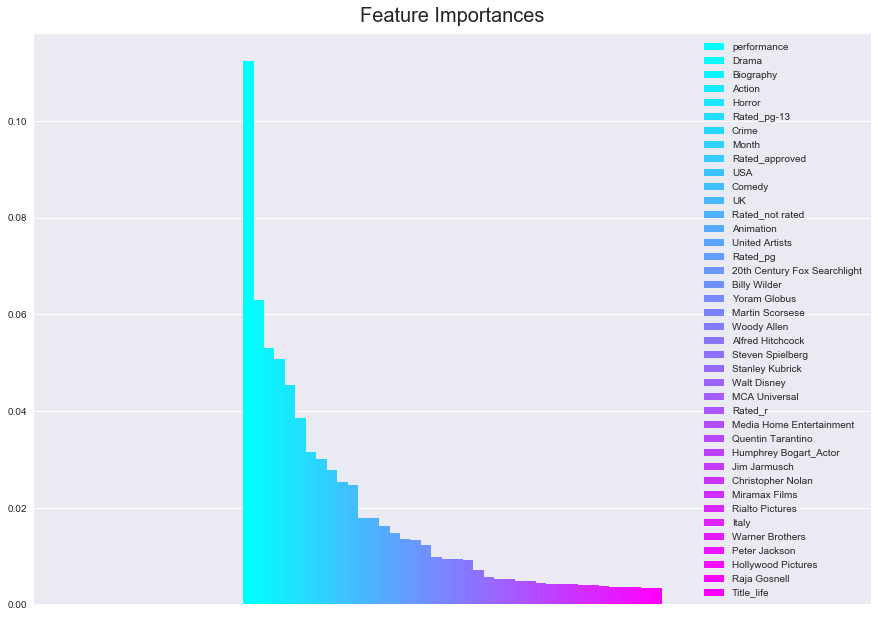

In [419]:
fig, ax = plt.subplots(figsize=(15,10.5))
importances4.plot(kind='bar', ax=ax, colormap='cool')
ax.set_title('Feature Importances', fontsize=20, y=1.01)
ax.get_xaxis().set_visible(False)

In [420]:
pred = model.predict(X3)

In [421]:
# conf matrix
cm = confusion_matrix(y3, pred)
cm = pd.DataFrame(cm, columns=["Predict Low Rating", "Predict Average Rating", "Predict High Rating"], \
                  index=["Low Rating", "Average Rating", "High Rating"] )
cm

,Predict Low Rating,Predict Average Rating,Predict High Rating
Low Rating,1050,98,246
Average Rating,874,374,710
High Rating,285,115,1040


In [422]:
class_re = classification_report(y3, pred)
print class_re

             precision    recall  f1-score   support

          0       0.48      0.75      0.58      1394
          1       0.64      0.19      0.29      1958
          2       0.52      0.72      0.61      1440

avg / total       0.56      0.51      0.47      4792



---

In [425]:
dropped = ['Rating_Labels','Award_wins', 'Award_noms', 'Oscar_wins', 'Oscar_noms', 'Year','RunTime', 'imdbVotes', 'Month']
X5 = df_1.drop(dropped, axis=1)
y5 = df_1['Rating_Labels']

In [426]:
X5.columns

Index([            u'Action',          u'Adventure',          u'Animation',
                u'Biography',             u'Comedy',              u'Crime',
                    u'Drama',             u'Family',            u'Fantasy',
                u'Film-Noir',
       ...
           u'Ashok Amritraj', u'Albert R. Broccoli',      u'Paul Davidson',
             u'Edward Small',   u'Louis D. Lighton',   u'Raymond Griffith',
               u'Nat Levine',         u'Sol Lesser',      u'William Goetz',
            u'Raymond Hakim'],
      dtype='object', length=1096)

In [427]:
rf5 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model5 = rf5.fit(X5, y5)

In [428]:
# feature importances 

feature_importances5 = pd.DataFrame(rf5.feature_importances_,
                                   index = X5.columns,
                                    columns=['importance'])
importances5 = feature_importances5.sort_values(by='importance', ascending=False).head(40).T
importances5

,Drama,Horror,USA,The Criterion Collection,Biography,Rated_approved,Action,Japan,Crime,India,...,Rated_r,Yoram Globus,Akira Kurosawa,Comedy,François Truffaut,Jesús Franco,Unknown,Ingmar Bergman,Warner Brothers,Title_ii
importance,0.067423,0.064672,0.063639,0.053409,0.047551,0.046769,0.043053,0.035416,0.030836,0.030523,...,0.005775,0.005639,0.005498,0.00528,0.005131,0.004948,0.004532,0.004141,0.003869,0.003685


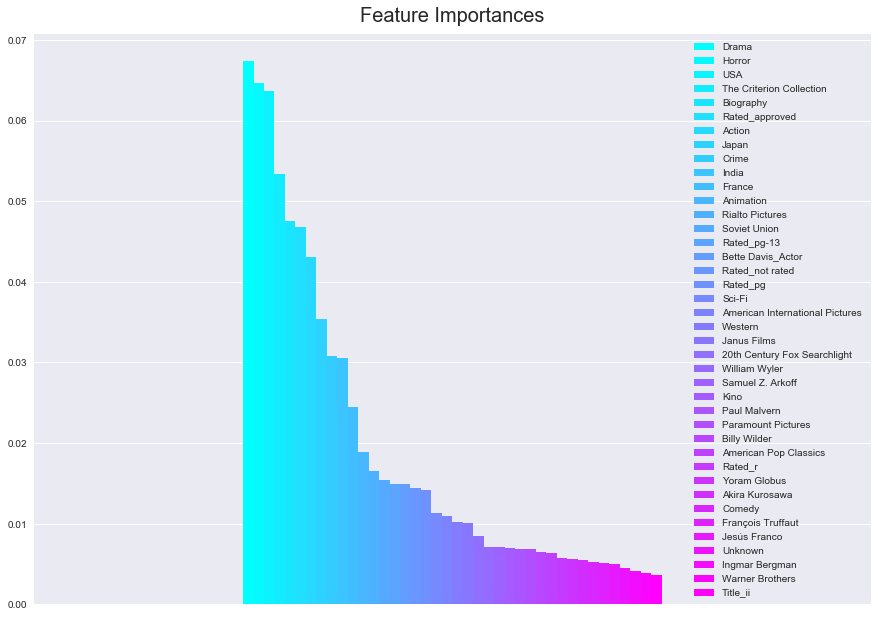

In [430]:
fig, ax = plt.subplots(figsize=(15,10.5))
importances5.plot(kind='bar', ax=ax, colormap='cool')
ax.set_title('Feature Importances', fontsize=20, y=1.01)
ax.get_xaxis().set_visible(False)

In [431]:
pred = model5.predict(X5)

In [432]:
# conf matrix
cm = confusion_matrix(y5, pred)
cm = pd.DataFrame(cm, columns=["Predict Low Rating", "Predict Average Rating", "Predict High Rating"], \
                  index=["Low Rating", "Average Rating", "High Rating"] )
cm

,Predict Low Rating,Predict Average Rating,Predict High Rating
Low Rating,2608,707,1089
Average Rating,2267,2148,1929
High Rating,911,921,2357


In [433]:
class_re = classification_report(y5, pred)
print class_re

             precision    recall  f1-score   support

          0       0.45      0.59      0.51      4404
          1       0.57      0.34      0.42      6344
          2       0.44      0.56      0.49      4189

avg / total       0.50      0.48      0.47     14937



In [806]:
df_meta = df_1.dropna()

In [807]:
df_meta.shape

(3542, 1118)

In [808]:
dropped = ['Rating_Labels']
X6 = df_meta.drop(dropped, axis=1)
y6 = df_meta['Rating_Labels']

In [811]:
rf6 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model6 = rf6.fit(X6, y6)

In [812]:
# feature importances 

feature_importances6 = pd.DataFrame(rf6.feature_importances_,
                                   index = X6.columns,
                                    columns=['importance'])
importances6 = feature_importances6.sort_values(by='importance', ascending=False).head(40).T
importances6

,Metascore,Award_wins,Award_noms,imdbVotes,Oscar_wins,RunTime,Oscar_noms,Year,USA,Rated_pg-13,...,Raja Gosnell,Dennis Dugan,Hong Kong,Christopher Nolan,Focus Features,Screen Gems,20th Century Fox,France,United Artists,Spain
importance,0.127718,0.102187,0.091084,0.073473,0.065319,0.058419,0.053647,0.043498,0.029794,0.020481,...,0.002558,0.0023,0.002295,0.00219,0.002186,0.002165,0.002143,0.002133,0.002098,0.002073


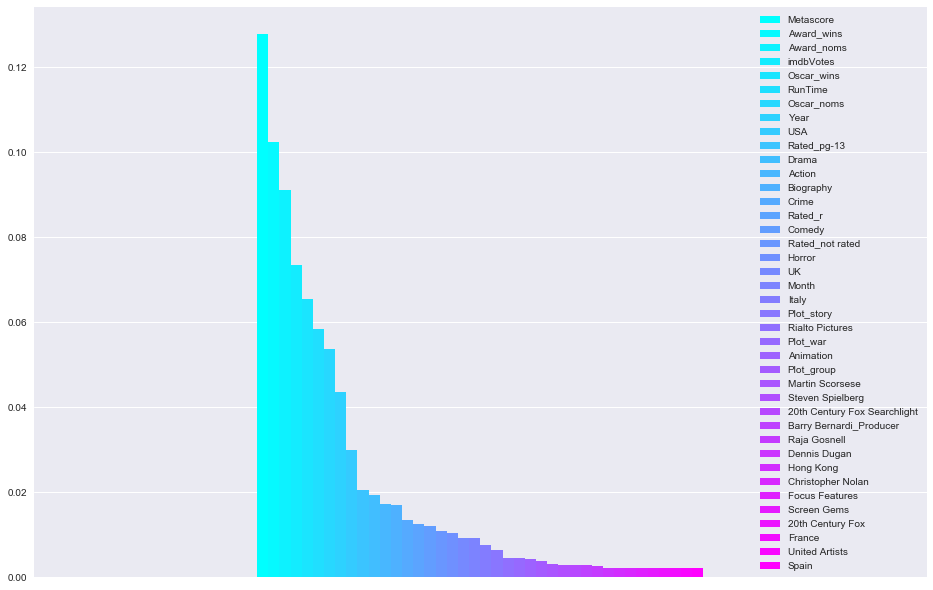

In [813]:
fig, ax = plt.subplots(figsize=(16,10.5))
importances6.plot(kind='bar', ax=ax, colormap='cool')
ax.get_xaxis().set_visible(False)

In [814]:
pred6 = model6.predict(X6)

In [815]:
# conf matrix
cm = confusion_matrix(y6, pred6)
cm = pd.DataFrame(cm, columns=["Predict Low Rating", "Predict Average Rating", "Predict High Rating"], \
                  index=["Low Rating", "Average Rating", "High Rating"] )
cm

,Predict Low Rating,Predict Average Rating,Predict High Rating
Low Rating,809,45,40
Average Rating,661,371,378
High Rating,76,116,1046


In [816]:
class_re = classification_report(y6, pred6)
print class_re

             precision    recall  f1-score   support

          0       0.52      0.90      0.66       894
          1       0.70      0.26      0.38      1410
          2       0.71      0.84      0.77      1238

avg / total       0.66      0.63      0.59      3542



In [817]:
dropped = ['Rating_Labels', 'Year', 'RunTime', 'Month']
X7 = df_meta.drop(dropped, axis=1)
y7 = df_meta['Rating_Labels']

In [818]:
rf7 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model7 = rf7.fit(X7, y7)

In [819]:
# feature importances 

feature_importances7 = pd.DataFrame(rf7.feature_importances_,
                                   index = X7.columns,
                                    columns=['importance'])
importances7 = feature_importances7.sort_values(by='importance', ascending=False).head(40).T
importances7

,Metascore,Award_wins,Award_noms,imdbVotes,Oscar_wins,Oscar_noms,USA,Drama,Rated_pg-13,Action,...,20th Century Fox,Barry Bernardi_Producer,Hong Kong,Dennis Dugan,Steven Spielberg,Universal Pictures,Focus Features,Rated_approved,Joel & Ethan Coen,Tom Hanks_Actor
importance,0.143986,0.112277,0.084018,0.083653,0.066946,0.059621,0.034678,0.025029,0.024183,0.022715,...,0.002813,0.002721,0.002689,0.002635,0.002455,0.002351,0.00216,0.00204,0.001976,0.001962


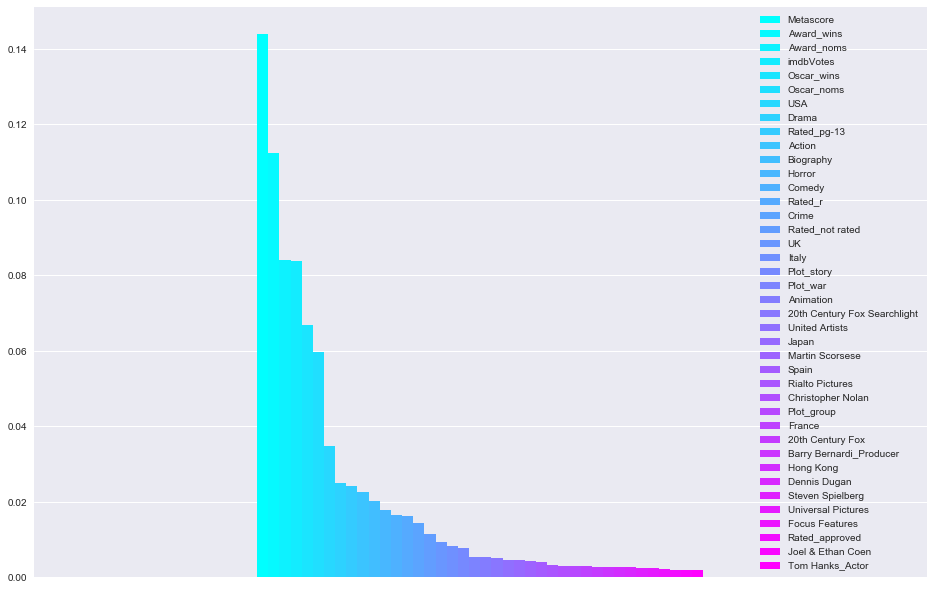

In [820]:
fig, ax = plt.subplots(figsize=(16,10.5))
importances7.plot(kind='bar', ax=ax, colormap='cool')
ax.get_xaxis().set_visible(False)

In [822]:
pred7 = model7.predict(X7)

In [826]:
df.head()

,Metascore,Rated,Year,imdbID,imdbRating,imdbVotes,Month,Oscar_wins,Oscar_noms,Award_wins,...,Paul Davidson_Producer,Edward Small_Producer,Louis D. Lighton_Producer,Raymond Griffith_Producer,Luc Besson_Producer,Nat Levine_Producer,Sol Lesser_Producer,William Goetz_Producer,Raymond Hakim_Producer,Rating_Labels
0,NaN,approved,1957,tt0050210,5.3,1109,10.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,approved,1938,tt0030725,4.6,159,3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,pg,1957,tt0050212,8.2,156900,12.0,7,0,23,...,0,0,0,0,0,0,0,0,0,2
3,90.0,r,2004,tt0381681,8.0,175947,7.0,0,1,9,...,0,0,0,0,0,0,0,0,0,2
4,48.0,pg,2006,tt0472160,6.8,52218,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [827]:
dfp = pd.merge(df, performance, how='left')

In [828]:
dfp.dropna(inplace=True)

In [830]:
dfp.shape

(2936, 1129)

In [831]:
dropped = ['Rating_Labels']
X8 = dfp.drop(dropped, axis=1)
y8 = dfp['Rating_Labels']

In [833]:
X8.drop(drop_for_sklearn, axis=1, inplace=True)

In [834]:
rf8 = RandomForestClassifier(n_estimators=1000, max_depth = 5, class_weight='balanced')
model8 = rf8.fit(X8, y8)

In [835]:
# feature importances 

feature_importances8 = pd.DataFrame(rf8.feature_importances_,
                                   index = X8.columns,
                                    columns=['importance'])
importances8 = feature_importances8.sort_values(by='importance', ascending=False).head(40).T
importances8

,Metascore,Award_wins,imdbVotes,Award_noms,Oscar_wins,RunTime,performance,Oscar_noms,Year,Rated_pg-13,...,Christopher Nolan,Joel & Ethan Coen,James Cameron,Screen Gems,Woody Allen,Barry Bernardi_Producer,Universal Pictures,Paul W.S. Anderson,Rialto Pictures,Lionsgate Films
importance,0.130855,0.118768,0.081848,0.078596,0.067704,0.061701,0.048099,0.047521,0.040015,0.019101,...,0.002377,0.001992,0.001733,0.0017,0.001663,0.001648,0.001575,0.001475,0.001418,0.001412


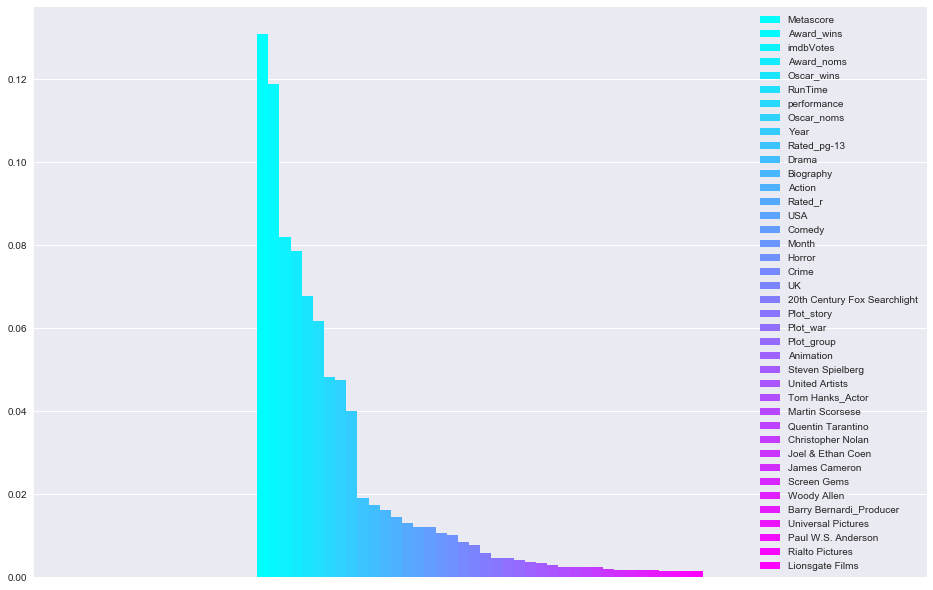

In [836]:
fig, ax = plt.subplots(figsize=(16,10.5))
importances8.plot(kind='bar', ax=ax, colormap='cool')
ax.get_xaxis().set_visible(False)

In [837]:
importances8d = feature_importances8.sort_values(by='importance', ascending=False).T
importances8d

,Metascore,Award_wins,imdbVotes,Award_noms,Oscar_wins,RunTime,performance,Oscar_noms,Year,Rated_pg-13,...,James Neilson,Ted Post,Spencer Gordon Bennet,George Archainbaud,Antonio Margheriti,George Melford,Leslie Fenton,August Blom,Oscar Apfel,Ernst Hofbauer
importance,0.130855,0.118768,0.081848,0.078596,0.067704,0.061701,0.048099,0.047521,0.040015,0.019101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [838]:
directors_5up
for i in directors_5up:
    try:
        importances8dx = importances8d.drop(i, axis=1)
    except:
        pass

In [839]:
importances8dx.head()

,Metascore,Award_wins,imdbVotes,Award_noms,Oscar_wins,RunTime,performance,Oscar_noms,Year,Rated_pg-13,...,James Neilson,Ted Post,Spencer Gordon Bennet,George Archainbaud,Antonio Margheriti,George Melford,Leslie Fenton,August Blom,Oscar Apfel,Ernst Hofbauer
importance,0.130855,0.118768,0.081848,0.078596,0.067704,0.061701,0.048099,0.047521,0.040015,0.019101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Notes for further work

In [434]:
# directors comprise half of our features 682, so diluted? sum importances of directors
# run h2o model
# metascore

In [ ]:
# plot genre - rating, month - rating, production - rating, genre - performance, year - genre, year - rating

In [ ]:
# get and use writer

In [ ]:
# h20
# output csv of features
# nans? 

# run h20 in a new notebook

In [ ]:
# tomatoes??

In [ ]:
# sum feature importances
# sum director feature importances

In [ ]:
# feature correlation
# feature colinearity?